In this tutorial, we show how to use RipsNet to learn the topology of very simple synthetic data sets comprised of (noisy) circles. Let's first define the seed (for reproducibility), the number of point clouds that we will use for training RipsNet, the number of point clouds we will use to test it, the cardinality of the point clouds and finally the amount of corrupted points (when noise is added).

In [1]:
N_sets_train = 900  # Number of train point clouds
N_sets_test  = 300  # Number of test  point clouds
N_points     = 600  # Point cloud cardinality
N_noise      = 200  # Number of corrupted points

## Initialization

### Imports


In [2]:
!pip install gudhi tqdm matplotlib scikit-learn scipy torch xgboost POT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 89.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import gudhi as gd
from gudhi.representations import DiagramSelector, Landscape, PersistenceImage
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adamax
from xgboost import XGBClassifier

###utils


#### Layer definitions

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adamax

class DenseRagged(nn.Module):
    def __init__(self, in_features=None, out_features=30, activation='relu', use_bias=True):
        super(DenseRagged, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.activation = activation

        self.weight = None
        self.bias = None

    def forward(self, inputs):
        outputs = []
        for x in inputs:
            if self.weight is None:
                in_features = x.shape[-1]
                self.weight = nn.Parameter(torch.randn(in_features, self.out_features) * 0.01)
                if self.use_bias:
                    self.bias = nn.Parameter(torch.zeros(self.out_features))
            y = torch.matmul(x, self.weight)
            if self.use_bias:
                y = y + self.bias
            if self.activation == 'relu':
                y = F.relu(y)
            elif self.activation == 'sigmoid':
                y = torch.sigmoid(y)
            elif self.activation == 'tanh':
                y = torch.tanh(y)
            outputs.append(y)
        return outputs


class PermopRagged(nn.Module):
    def forward(self, inputs):
        return torch.stack([torch.sum(x, dim=0) for x in inputs])


class RaggedPersistenceModel(nn.Module):
    def __init__(self, output_dim):
        super(RaggedPersistenceModel, self).__init__()
        self.ragged_layers = nn.ModuleList([
            DenseRagged(out_features=30, activation='relu'),
            DenseRagged(out_features=20, activation='relu'),
            DenseRagged(out_features=10, activation='relu')
        ])
        self.perm = PermopRagged()

        self.fc = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, output_dim),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        x = inputs
        for layer in self.ragged_layers:
            x = layer(x)
        x = self.perm(x)
        x = self.fc(x)
        return x

#### Point Cloud

In [5]:
import numpy as np
from tqdm import tqdm
import gudhi as gd


####################################
###  Creation of point clouds    ###
####################################

def create_circle(N_points, r, x_0, y_0):
    X = []
    for i in range(N_points):
        theta = np.random.uniform() * 2 * np.pi
        X.append([(r * np.cos(theta)) + x_0, (r * np.sin(theta) + y_0)])
    return np.array(X)


def create_1_circle_clean(N_points):
    r = 2
    x_0, y_0 = 10 * np.random.rand() - 5, 10 * np.random.rand() - 5
    return create_circle(N_points, r, x_0, y_0)


def create_2_circle_clean(N_points):
    r1 = 5
    r2 = 3
    x_0, y_0 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    while np.sqrt((x_0 - x_1) ** 2 + (y_0 - y_1) ** 2) <= r1 + r2:
        x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    circle1 = create_circle(N_points // 2, r1, x_0, y_0)
    circle2 = create_circle(N_points - N_points // 2, r2, x_1, y_1)
    X = [0] * N_points
    X[:N_points // 2] = circle1
    X[N_points // 2:] = circle2
    np.random.shuffle(X)
    return np.array(X)


def create_3_circle_clean(N_points):
    r0 = 5
    r1 = 3
    r2 = 2
    x_0, y_0 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    while np.sqrt((x_0 - x_1) ** 2 + (y_0 - y_1) ** 2) <= r0 + r1:
        x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15

    x_2, y_2 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    while(np.sqrt((x_0 - x_2)**2 + (y_0 - y_2)**2) <= r0 + r2) or (np.sqrt((x_1 - x_2)**2 + (y_1 - y_2)**2) <= r1 + r2):
        x_2, y_2 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15

    circle0 = create_circle(N_points // 3, r0, x_0, y_0)
    circle1 = create_circle(N_points // 3, r1, x_1, y_1)
    circle2 = create_circle(N_points // 3, r2, x_2, y_2)

    # Handler in case N_points mod 3 != 0.
    true_N_points = 3 * (N_points // 3)

    X = [[0,0]] * true_N_points
    X[:true_N_points // 3] = circle0
    X[true_N_points // 3:2 * true_N_points // 3] = circle1
    X[2 * true_N_points // 3:] = circle2
    np.random.shuffle(X)
    return np.array(X)


def create_1_circle_noisy(N_points, N_noise):
    r = 2
    x_0, y_0 = 10 * np.random.rand() - 5, 10 * np.random.rand() - 5
    X = create_circle(N_points, r, x_0, y_0)
    noise = []
    for i in range(N_noise):
        noise.append([np.random.uniform(x_0 - r, x_0 + r),
                      np.random.uniform(y_0 - r, y_0 + r)])
    X = np.array(X)
    X[np.random.choice(np.arange(len(X)), size=N_noise, replace=False, p=None)] = np.array(noise)
    return X


def create_2_circle_noisy(N_points, N_noise):
    r1 = 5
    r2 = 3
    x_0, y_0 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    while(np.sqrt((x_0 - x_1)**2 + (y_0 - y_1)**2) <= r1 + r2):
        x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    circle1 = create_circle(N_points // 2, r1, x_0, y_0)
    circle2 = create_circle(N_points - N_points // 2, r2, x_1, y_1)
    X = [0] * N_points
    X[:N_points // 2] = circle1
    X[N_points // 2:] = circle2
    np.random.shuffle(X)
    noise = []
    for i in range(N_noise):
        noise.append([np.random.uniform(min(x_0 - r1, x_1 - r2), max(x_0 + r1, x_1 + r2)),
                      np.random.uniform(min(y_0 - r1, y_1 - r2), max(y_0 + r1, y_1 + r2))])
    X = np.array(X)
    X[np.random.choice(np.arange(len(X)), size=N_noise, replace=False, p=None)] = np.array(noise)
    return X


def create_3_circle_noisy(N_points, N_noise):
    r0 = 5
    r1 = 3
    r2 = 2
    x_0, y_0 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    while np.sqrt((x_0 - x_1) ** 2 + (y_0 - y_1) ** 2) <= r0 + r1:
        x_1, y_1 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    x_2, y_2 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    while(np.sqrt((x_0 - x_2)**2 + (y_0 - y_2)**2) <= r0 + r2) or (np.sqrt((x_1 - x_2)**2 + (y_1 - y_2)**2) <= r1 + r2):
        x_2, y_2 = 30 * np.random.rand() - 15, 30 * np.random.rand() - 15
    circle0 = create_circle(N_points // 3, r0, x_0, y_0)
    circle1 = create_circle(N_points // 3, r1, x_1, y_1)
    circle2 = create_circle(N_points // 3, r2, x_2, y_2)

    true_N_points = 3 * (N_points // 3)
    X = [[0,0]] * true_N_points
    X[:true_N_points // 3] = circle0
    X[true_N_points // 3:2 * true_N_points // 3] = circle1
    X[2 * true_N_points // 3:] = circle2

    np.random.shuffle(X)
    noise = []
    for i in range(N_noise):
        noise.append([np.random.uniform(np.min([x_0 - r0, x_1 - r1, x_2 - r2]), np.max([x_0 + r0, x_1 + r1, x_2 + r2])),
                      np.random.uniform(np.min([y_0 - r0, y_1 - r1, y_2 - r2]), np.max([y_0 + r0, y_1 + r1, y_2 + r2]))])
    X = np.array(X)
    X[np.random.choice(np.arange(len(X)), size=N_noise, replace=False, p=None)] = np.array(noise)
    return X

def augment_isometries(pc, n, rng, trans_frac=0.08):
    bbox = pc.max(axis=0) - pc.min(axis=0)
    t_max = trans_frac * np.linalg.norm(bbox)  # translation scale relative to cloud size
    augmented = []
    for _ in range(n):
        theta = rng.uniform(0, 2 * np.pi)
        R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        t = rng.uniform(-t_max, t_max, size=2)
        augmented.append((pc @ R.T) + t)
    return augmented

def data_augmentation_by_isometries(data_train, label_train, n_augment_per_sample, seed=42):
    rng = np.random.default_rng(seed)
    aug_data, aug_labels = [], []
    for pc, lbl in zip(data_train, label_train):
        aug_data.append(pc)
        aug_labels.append(lbl)
        for pc_aug in augment_isometries(pc, n_augment_per_sample, rng):
            aug_data.append(pc_aug)
            aug_labels.append(lbl)
    return aug_data, aug_labels

def augment_permutations(pc, n, rng):
    augmented = []
    for _ in range(n):
        shuffled_pc = rng.permutation(pc, axis=0) # Permute rows (points) of the point cloud
        augmented.append(shuffled_pc)
    return augmented

def create_multiple_circles(N_sets_train, N_points, noisy=False, N_noise=0, n_augment_per_sample = 0):

    data_train, PD_train = [[] for _ in range(N_sets_train)], []
    label_train = np.zeros((N_sets_train,))

    if not noisy:
        for i in tqdm(range(N_sets_train // 3)):
            data_train[i] = create_1_circle_clean(N_points)
            label_train[i] = 1
        for i in tqdm(range(N_sets_train // 3, 2 * N_sets_train // 3)):
            data_train[i] = create_2_circle_clean(N_points)
            label_train[i] = 2
        for i in tqdm(range(2 * N_sets_train // 3, N_sets_train)):
            data_train[i] = create_3_circle_clean(N_points)
            label_train[i] = 3
    else:
        for i in tqdm(range(N_sets_train // 3)):
            data_train[i] = create_1_circle_noisy(N_points, N_noise)
            label_train[i] = 1
        for i in tqdm(range(N_sets_train // 3, 2 * N_sets_train // 3)):
            data_train[i] = create_2_circle_noisy(N_points, N_noise)
            label_train[i] = 2
        for i in tqdm(range(2 * N_sets_train // 3, N_sets_train)):
            data_train[i] = create_3_circle_noisy(N_points, N_noise)
            label_train[i] = 3

    shuffler = np.random.permutation(len(data_train))
    label_train = label_train[shuffler]
    data_train = [data_train[p] for p in shuffler]
    if (n_augment_per_sample > 0):
        data_train,label_train = data_augmentation_by_isometries(data_train, label_train, n_augment_per_sample, seed=42)
    return data_train, label_train


############################################
### Computation of persistence diagrams  ###
############################################


def compute_PD(dataset, i):
    u = np.array(dataset[i])
    rcX = gd.AlphaComplex(points=u).create_simplex_tree()
    rcX.persistence()
    dgm = rcX.persistence_intervals_in_dimension(1)
    return dgm

#### Training functions

In [6]:
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

def train_model(model, optimizer, criterion, train_inputs, train_targets, val_inputs, val_targets, epochs=20, batch_size=32):
    """
    Train a ragged-input model. Returns (best_model, history, best_model_state).
    """
    model = model.to(device)
    patience = 20
    best_val_loss = float('inf')
    patience_counter = 0
    num_epochs = epochs if epochs is not None else 10000
    history = {'train_loss': [], 'val_loss': []}
    best_model_state = None

    # helper to move inputs to device
    def to_device_list(lst):
        out = []
        for x in lst:
            if isinstance(x, torch.Tensor):
                out.append(x.to(device).float())
            else:
                out.append(torch.tensor(x, dtype=torch.float32, device=device))
        return out

    train_inputs = to_device_list(train_inputs)
    val_inputs = to_device_list(val_inputs)

    if isinstance(train_targets, torch.Tensor):
        train_targets = train_targets.to(device).float()
    else:
        train_targets = torch.tensor(train_targets, dtype=torch.float32, device=device)

    if isinstance(val_targets, torch.Tensor):
        val_targets = val_targets.to(device).float()
    else:
        val_targets = torch.tensor(val_targets, dtype=torch.float32, device=device)

    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(len(train_inputs), device=device)
        epoch_loss = 0.0
        for i in range(0, len(train_inputs), batch_size):
            optimizer.zero_grad()
            indices = permutation[i:i + batch_size]
            batch_inputs = [train_inputs[int(idx)].to(device) for idx in indices]
            batch_targets = train_targets[indices]

            outputs = model(batch_inputs)
            if isinstance(outputs, (list, tuple)):
                outputs = outputs[0]
            if not isinstance(outputs, torch.Tensor):
                outputs = torch.tensor(outputs, dtype=batch_targets.dtype, device=device)
            else:
                outputs = outputs.to(device).type(batch_targets.dtype)

            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(batch_inputs)

        epoch_loss /= len(train_inputs)
        history['train_loss'].append(epoch_loss)

        model.eval()
        with torch.no_grad():
            val_outputs = model(val_inputs)
            if isinstance(val_outputs, (list, tuple)):
                val_outputs = val_outputs[0]
            val_outputs = val_outputs.to(device).type(val_targets.dtype)
            val_loss = criterion(val_outputs, val_targets).item()
            history['val_loss'].append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.6f}, Val Loss: {val_loss:.6f}')

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            patience_counter = 0
            # save best model (on CPU to avoid holding GPU memory)
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # if we saved a best state, load it back into the model on the current device
    if best_model_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})

    return model, history, best_model_state

In [77]:
def get_ensemble_input_from_pc(pc, device, descriptor_type):
    # pc is a numpy array
    # descriptor_type: 'pi' or 'pl'

    # Ensure PC is a list of tensors for models expecting ragged inputs
    pc_tensor_list = [torch.tensor(pc, dtype=torch.float32).to(device)]

    # --- 1. Get raw descriptors/predictions from base models ---
    # Gudhi (requires re-computation of PD and then PI/PL transform)
    st = gd.AlphaComplex(points=pc).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    # DiagramSelector expects a list of diagrams
    pds_pc = DiagramSelector(use=True).fit_transform([dg])

    if descriptor_type == 'pi':
        gudhi_descriptor = PI.transform(pds_pc)
        rn_descriptor = model_PI(pc_tensor_list).detach().cpu().numpy()
        # Distance Matrix model
        dm = distance_matrix(pc)
        dm_descriptor = model_dm_pi([torch.tensor(dm, dtype=torch.float32).to(device)]).detach().cpu().numpy()
        pn_descriptor = model_PN_PI(pc_tensor_list).detach().cpu().numpy()

        # Ensure outputs are normalized consistently with training data for XGBoost
        gudhi_descriptor = gudhi_descriptor / MPI
        rn_descriptor = rn_descriptor / MPI
        dm_descriptor = dm_descriptor / MPI
        pn_descriptor = pn_descriptor / MPI

        # Ensure all descriptors are 2D arrays for predict_proba
        gudhi_descriptor = gudhi_descriptor.reshape(1, -1)
        rn_descriptor = rn_descriptor.reshape(1, -1)
        dm_descriptor = dm_descriptor.reshape(1, -1)
        pn_descriptor = pn_descriptor.reshape(1, -1)

        # --- 2. Get probabilities from base XGBoost classifiers ---
        proba_gudhi = model_classif_gudhi_pi_base.predict_proba(gudhi_descriptor)
        proba_ripsnet = model_classif_RN_pi_base.predict_proba(rn_descriptor)
        proba_dm = model_classif_dm_pi_base.predict_proba(dm_descriptor)
        proba_pointnet = model_classif_PN_pi_base.predict_proba(pn_descriptor)

    elif descriptor_type == 'pl':
        gudhi_descriptor = PL.transform(pds_pc)
        rn_descriptor = model_PL(pc_tensor_list).detach().cpu().numpy()
        # Distance Matrix model
        dm = distance_matrix(pc)
        dm_descriptor = model_dm_pl([torch.tensor(dm, dtype=torch.float32).to(device)]).detach().cpu().numpy()
        pn_descriptor = model_PN_PL(pc_tensor_list).detach().cpu().numpy()

        # Ensure outputs are normalized consistently with training data for XGBoost
        gudhi_descriptor = gudhi_descriptor / MPL
        rn_descriptor = rn_descriptor / MPL
        dm_descriptor = dm_descriptor / MPL
        pn_descriptor = pn_descriptor / MPL

        # Ensure all descriptors are 2D for predict_proba
        gudhi_descriptor = gudhi_descriptor.reshape(1, -1)
        rn_descriptor = rn_descriptor.reshape(1, -1)
        dm_descriptor = dm_descriptor.reshape(1, -1)
        pn_descriptor = pn_descriptor.reshape(1, -1)

        # --- 2. Get probabilities from base XGBoost classifiers ---
        proba_gudhi = model_classif_gudhi_pl_base.predict_proba(gudhi_descriptor)
        proba_ripsnet = model_classif_RN_pl_base.predict_proba(rn_descriptor)
        proba_dm = model_classif_dm_pl_base.predict_proba(dm_descriptor)
        proba_pointnet = model_classif_PN_pl_base.predict_proba(pn_descriptor)
    else:
        raise ValueError("descriptor_type must be 'pi' or 'pl'")

    # Concatenate probabilities to form input for ensemble model
    # Exclude proba_gudhi as the ensemble model was trained without it.
    ensemble_input = np.concatenate([proba_ripsnet, proba_dm, proba_pointnet], axis=1)
    return ensemble_input.flatten()

def compute_ensemble_robustness(pc, ensemble_model, augmentation_fn, n_augment_per_score, device, descriptor_type, seed=42):
    rng = np.random.default_rng(seed)
    # LogisticRegression does not have an 'eval' mode like torch.nn.Module, so skip if not applicable
    if isinstance(ensemble_model, torch.nn.Module):
        ensemble_model.eval()

    # Get ensemble input for the original point cloud
    ensemble_input_original = get_ensemble_input_from_pc(pc, device, descriptor_type)

    # Predict probabilities with the ensemble model
    # LogisticRegression expects 2D array, so reshape if needed
    pred_original_ensemble = ensemble_model.predict_proba(ensemble_input_original.reshape(1, -1)).flatten()

    augmented_pcs = augmentation_fn(pc, n_augment_per_score, rng)

    euclidean_distances = []
    for aug_pc in augmented_pcs:
        ensemble_input_augmented = get_ensemble_input_from_pc(aug_pc, device, descriptor_type)
        pred_augmented_ensemble = ensemble_model.predict_proba(ensemble_input_augmented.reshape(1, -1)).flatten()
        dist = np.linalg.norm(pred_original_ensemble - pred_augmented_ensemble)
        euclidean_distances.append(dist)

    if len(euclidean_distances) > 0:
        return np.mean(euclidean_distances), np.std(euclidean_distances)
    else:
        return 0.0, 0.0

print("Helper functions for ensemble robustness defined.")

Helper functions for ensemble robustness defined.


### Definition of our Train/Test sets
Next we use helper functions to compute these point clouds.

In [8]:
data_train,      label_train       = create_multiple_circles(N_sets_train, N_points, noisy=0, N_noise=N_noise, n_augment_per_sample= 0)
clean_data_test, clean_label_test  = create_multiple_circles(N_sets_test,  N_points, noisy=0, N_noise=N_noise,n_augment_per_sample= 0)
noisy_data_test, noisy_label_test  = create_multiple_circles(N_sets_test,  N_points, noisy=1, N_noise=N_noise)

100%|██████████| 100/100 [00:01<00:00, 88.69it/s]


In [9]:
import numpy as np

def compute_trace_PpT(P: np.ndarray) -> float:
    if P.ndim == 1:
        P = P.reshape(1, -1)
    return np.sum(np.linalg.norm(P, axis=1)**2)

In [10]:
ppT_trace_train = []
for pc in tqdm(data_train, desc='Computing trace(P @ P.T) for training data'):
    ppT_trace_train.append(compute_trace_PpT(pc))

ppT_trace_clean_test = []
for pc in tqdm(clean_data_test, desc='Computing trace(P @ P.T) for clean test data'):
    ppT_trace_clean_test.append(compute_trace_PpT(pc))

ppT_trace_noisy_test = []
for pc in tqdm(noisy_data_test, desc='Computing trace(P @ P.T) for noisy test data'):
    ppT_trace_noisy_test.append(compute_trace_PpT(pc))

Computing trace(P @ P.T) for noisy test data: 100%|██████████| 300/300 [00:00<00:00, 21527.65it/s]


Let's check some of these point clouds!

#### Plotting Point Clouds

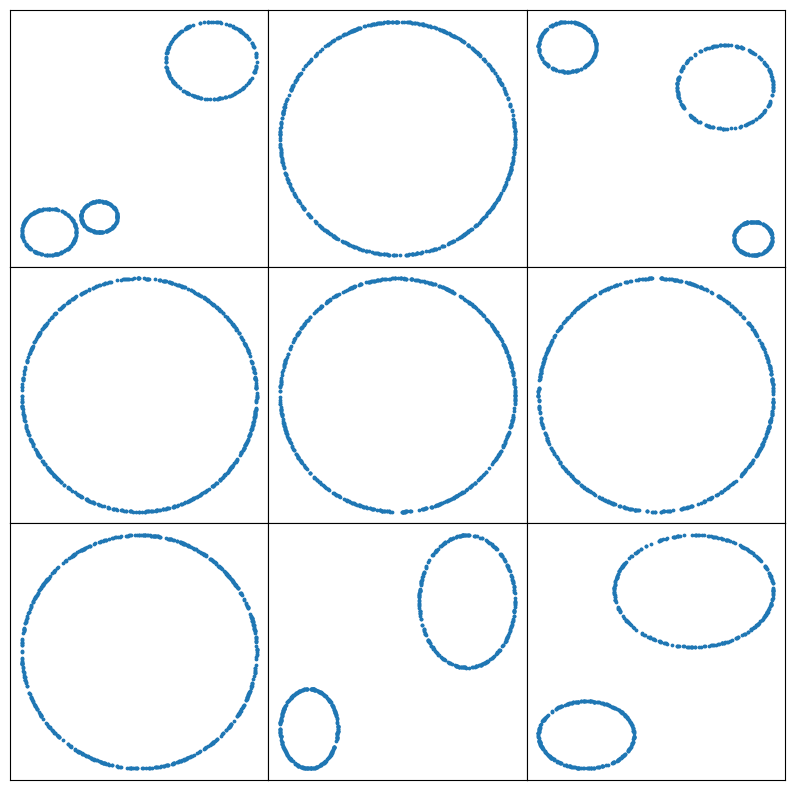

In [11]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(clean_data_test[3*i+j][:,0], clean_data_test[3*i+j][:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')

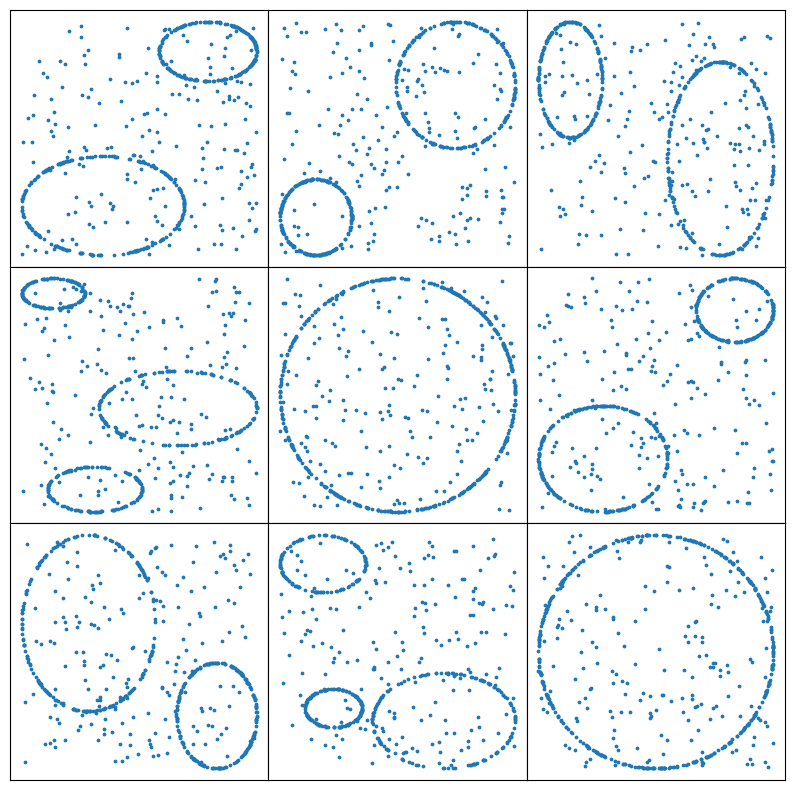

In [12]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(noisy_data_test[3*i+j][:,0], noisy_data_test[3*i+j][:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('noisy_gudhi_pc.png', bbox_inches='tight')

#### Cleaning Labels
As one can see, they contain 1 to 3 circular shapes. We will use these circle numbers later for checking the accuracy of the topology computed by RipsNet. For now, let's save them as proper labels.

In [13]:
le = LabelEncoder().fit(label_train)
label_classif_train = le.transform(label_train)
clean_label_classif_test  = le.transform(clean_label_test)
noisy_label_classif_test  = le.transform(noisy_label_test)

#### Distance Matrix


In [14]:
def distance_matrix(point_cloud):
    """
    Compute pairwise Euclidean distance matrix for a point cloud.
    Accepts numpy array, list-of-lists, or torch.Tensor of shape (N, d).
    Returns a numpy array of shape (N, N).
    """
    # rely on existing imports: np, torch
    if isinstance(point_cloud, __import__("torch").Tensor):
        point_cloud = point_cloud.cpu().numpy()
    pc = np.asarray(point_cloud, dtype=float)
    if pc.ndim == 1:
        pc = pc.reshape(-1, 1)
    diff = pc[:, None, :] - pc[None, :, :]
    return np.sqrt((diff ** 2).sum(axis=-1))

In [15]:
dm_train = []
for X in tqdm(data_train, desc='Computing DM for training data'):
    dm_train.append(distance_matrix(X))

dm_clean_test = []
for X in tqdm(clean_data_test, desc='Computing DM for clean test data'):
    dm_clean_test.append(distance_matrix(X))

dm_noisy_test = []
for X in tqdm(noisy_data_test, desc='Computing DM for noisy test data'):
    dm_noisy_test.append(distance_matrix(X))

print(f"Shape of first training distance matrix: {dm_train[0].shape}")
print(f"Shape of first clean test distance matrix: {dm_clean_test[0].shape}")
print(f"Shape of first noisy test distance matrix: {dm_noisy_test[0].shape}")

Computing DM for noisy test data: 100%|██████████| 300/300 [00:03<00:00, 79.22it/s]

Shape of first training distance matrix: (600, 600)
Shape of first clean test distance matrix: (600, 600)
Shape of first noisy test distance matrix: (600, 600)


### Topology of point clouds

In order to train RipsNet or other DL models, we need the correct topology on the train  data. So let's compute it with [Gudhi](https://gudhi.inria.fr/python/latest/). The topology of point clouds can be inferred from several filtrations, so we will use a fast and sparse one (in 2D), namely the [Alpha filtration](https://gudhi.inria.fr/python/latest/alpha_complex_user.html). First, we need to get a sense of the maximal filtration value to use, which we will approximate with the largest pairwise distance of the first 30 point clouds.

In [16]:
ds = [pairwise_distances(X).flatten() for X in data_train[:30]]
maxd = np.max(np.concatenate(ds))

#### Persistence diagrams
Now, we can compute the persistence diagrams (in homology dimension 1) of the train, clean test and noisy test point clouds!

In [17]:
PD_train = []
for X in tqdm(data_train):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    PD_train.append(dg)

100%|██████████| 900/900 [00:12<00:00, 74.70it/s]


In [18]:
clean_PD_test = []
for X in tqdm(clean_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    clean_PD_test.append(dg)

100%|██████████| 300/300 [00:04<00:00, 65.21it/s]


In [19]:
noisy_PD_test = []
for X in tqdm(noisy_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    noisy_PD_test.append(dg)

100%|██████████| 300/300 [00:02<00:00, 144.72it/s]


#### Persistence Image & Persistence Landscape
RipsNet actually works on vectorizations of persistence diagrams (PDs), so we will try two: the [persistence image](https://jmlr.org/papers/volume18/16-337/16-337.pdf), and the [persistence landscape](https://jmlr.csail.mit.edu/papers/volume16/bubenik15a/bubenik15a.pdf). First, let's filter out any PD point with infinite coordinates.

In [20]:
pds_train      = DiagramSelector(use=True).fit_transform(PD_train)
clean_pds_test = DiagramSelector(use=True).fit_transform(clean_PD_test)
noisy_pds_test = DiagramSelector(use=True).fit_transform(noisy_PD_test)

Fortunately, Gudhi also has code for computing vectorizations!! However, before launching the computations, we have to estimate a few parameters: the image bandwidth (taken as the 20% quantile of the positive birth-persistence-transformed-PD pairwise distances),
and the image and landscape limits (taken as the min and max of birth-persistence-transformed-PD point coordinates).

In [21]:
vpdtr = np.vstack(pds_train)
pers = vpdtr[:,1]-vpdtr[:,0]
bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
sigma = np.quantile(ppers, .2)
im_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,0],1.), np.quantile(pers,0.), np.quantile(pers,1.)]
sp_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,1],1.)]

We can now compute and normalize the vectorizations (this can help RipsNet training)!

In [22]:
if 'im_bnds' not in locals() or im_bnds is None:
    all_points = np.concatenate(pds_train, axis=0)
    x_min, x_max = np.min(all_points[:, 0]), np.max(all_points[:, 0])
    y_min, y_max = np.min(all_points[:, 1]), np.max(all_points[:, 1])
    im_bnds = [x_min, x_max, y_min, y_max]

PI_params = {
    'bandwidth': sigma,
    'weight': lambda x: 10 * np.tanh(x[1]),
    'resolution': [50, 50],
    'im_range': im_bnds
}

PI = PersistenceImage(**PI_params)
PI.fit(pds_train)

PI_train = PI.transform(pds_train)
clean_PI_test = PI.transform(clean_pds_test)
noisy_PI_test = PI.transform(noisy_pds_test)

MPI = np.max(PI_train)
if MPI == 0 or np.isnan(MPI):
    raise ValueError("MPI (max value) is zero or NaN; check persistence diagrams.")
else:
    PI_train /= MPI
    clean_PI_test /= MPI
    noisy_PI_test /= MPI

PI_train = torch.tensor(PI_train, dtype=torch.float32)
clean_PI_test = torch.tensor(clean_PI_test, dtype=torch.float32)
noisy_PI_test = torch.tensor(noisy_PI_test, dtype=torch.float32)

print(f"PI_train shape: {PI_train.shape}")
print(f"clean_PI_test shape: {clean_PI_test.shape}")
print(f"noisy_PI_test shape: {noisy_PI_test.shape}")
print(f"Max pixel intensity (MPI): {MPI:.5f}")


PI_train shape: torch.Size([900, 2500])
clean_PI_test shape: torch.Size([300, 2500])
noisy_PI_test shape: torch.Size([300, 2500])
Max pixel intensity (MPI): 0.15462


In [23]:

if 'sp_bnds' not in locals() or sp_bnds is None:
    all_points = np.concatenate(pds_train, axis=0)
    x_min, x_max = np.min(all_points[:, 0]), np.max(all_points[:, 1])
    sp_bnds = [x_min, x_max]


PL_params = {
    'num_landscapes': 5,
    'resolution': 300,
    'sample_range': sp_bnds
}

PL = Landscape(**PL_params)
PL.fit(pds_train)

PL_train = PL.transform(pds_train)
clean_PL_test = PL.transform(clean_pds_test)
noisy_PL_test = PL.transform(noisy_pds_test)

MPL = np.max(PL_train)
if MPL == 0 or np.isnan(MPL):
    raise ValueError("MPL (max landscape value) is zero or NaN; check your persistence diagrams.")
else:
    PL_train /= MPL
    clean_PL_test /= MPL
    noisy_PL_test /= MPL

PL_train = torch.tensor(PL_train, dtype=torch.float32)
clean_PL_test = torch.tensor(clean_PL_test, dtype=torch.float32)
noisy_PL_test = torch.tensor(noisy_PL_test, dtype=torch.float32)

print(f"PL_train shape: {PL_train.shape}")
print(f"clean_PL_test shape: {clean_PL_test.shape}")
print(f"noisy_PL_test shape: {noisy_PL_test.shape}")
print(f"Max landscape value (MPL): {MPL:.5f}")


PL_train shape: torch.Size([900, 1500])
clean_PL_test shape: torch.Size([300, 1500])
noisy_PL_test shape: torch.Size([300, 1500])
Max landscape value (MPL): 17.62263


#### Convert Point Clouds to Ragged Tensors

In [24]:
tf_data_train = [torch.tensor(pc, dtype=torch.float32) for pc in data_train]
tf_clean_data_test = [torch.tensor(pc, dtype=torch.float32) for pc in clean_data_test]
tf_noisy_data_test = [torch.tensor(pc, dtype=torch.float32) for pc in noisy_data_test]

## Presentation of Models and Tests


### Models

#### RipsNet (RaggedPersistenceModel)

##### Presentation of RipsNet




**Structure:**
RipsNet, implemented as `RaggedPersistenceModel`, is a neural network designed to process varying-sized inputs (like point clouds) using a DeepSet-like architecture. It consists of:
1.  **Ragged Layers (`DenseRagged`):** These are essentially fully-connected layers applied independently to each point in the input point cloud. They learn per-point features. The `DenseRagged` class handles the variable size of point clouds by applying the same weights to each point and operating on lists of tensors.
2.  **Permutation-Invariant Pooling (`PermopRagged`):** After the ragged layers, a permutation-invariant operation (in this case, summation across all point features) is applied to aggregate the per-point features into a fixed-size global descriptor for the entire point cloud.
3.  **Fully Connected Layers (`fc`):** A series of standard fully-connected layers process the global descriptor to produce the final output, which is a vectorized topological descriptor (either a Persistence Image or a Persistence Landscape).

**Motivation:**
RipsNet was proposed to overcome the computational bottleneck of traditional Topological Data Analysis (TDA) methods, which are often slow when applied to large datasets. The key idea is to *learn* a mapping from raw point cloud data directly to stable topological descriptors (like Persistence Images or Landscapes), bypassing the explicit computation of persistence diagrams. This allows for faster processing of new data points and integrates topological feature extraction into an end-to-end learning framework. Its DeepSet architecture inherently handles the unordered nature of point clouds.

##### Implementation of RipsNet(code)

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Redefining DenseRagged to correctly handle device placement of dynamically created parameters
class DenseRagged(nn.Module):
    def __init__(self, in_features=None, out_features=30, activation='relu', use_bias=True):
        super(DenseRagged, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.activation = activation

        # Parameters will be initialized on first forward pass.
        self.weight_param = None # Use distinct names for registered parameters
        self.bias_param = None

    def forward(self, inputs):
        outputs = []
        for x in inputs:
            if self.weight_param is None: # Check if parameters have been initialized
                in_features = x.shape[-1]
                # Initialize weight on the same device as input x
                self.weight_param = nn.Parameter(torch.randn(in_features, self.out_features, device=x.device) * 0.01)
                self.register_parameter('weight_param', self.weight_param) # Register the parameter
                if self.use_bias:
                    # Initialize bias on the same device as input x
                    self.bias_param = nn.Parameter(torch.zeros(self.out_features, device=x.device))
                    self.register_parameter('bias_param', self.bias_param) # Register the parameter

            y = torch.matmul(x, self.weight_param) # Use the registered parameter
            if self.use_bias:
                y = y + self.bias_param # Use the registered parameter
            if self.activation == 'relu':
                y = F.relu(y)
            elif self.activation == 'sigmoid':
                y = torch.sigmoid(y)
            elif self.activation == 'tanh':
                y = torch.tanh(y)
            outputs.append(y)
        return outputs

# Redefining PermopRagged (no changes needed, but must be in scope if RaggedPersistenceModel is redefined)
class PermopRagged(nn.Module):
    def forward(self, inputs):
        return torch.stack([torch.sum(x, dim=0) for x in inputs])

# Redefining RaggedPersistenceModel to use the corrected DenseRagged
class RaggedPersistenceModel(nn.Module):
    def __init__(self, output_dim):
        super(RaggedPersistenceModel, self).__init__()
        self.ragged_layers = nn.ModuleList([
            DenseRagged(out_features=30, activation='relu'),
            DenseRagged(out_features=20, activation='relu'),
            DenseRagged(out_features=10, activation='relu')
        ])
        self.perm = PermopRagged()

        self.fc = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, output_dim),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        x = inputs
        for layer in self.ragged_layers:
            x = layer(x)
        x = self.perm(x)
        x = self.fc(x)
        return x

#### DistanceMatrixRaggedModel

##### Presentation of DistanceMatrixRaggedModel

**Structure:**
The `DistanceMatrixRaggedModel` is an adaptation designed to predict topological descriptors directly from pairwise distance matrices of point clouds. It incorporates optional Graph Neural Network (GNN) layers to enrich feature learning:
1.  **Per-Row MLP (`_phi_mlp`):** Each row of the input distance matrix is treated as a feature vector for a point. A multi-layer perceptron (MLP) transforms these per-row feature vectors into a higher-dimensional embedding for each point.
2.  **GNN-like Aggregation (Optional):** If `gnn_enabled` is true, the model constructs an adjacency matrix from the distance matrix (representing connections between points) and applies graph convolutional layers. These layers facilitate message passing and aggregation of features between neighboring points, allowing the model to learn context-aware features.
3.  **Global Pooling:** After the per-point feature extraction (and optional GNN layers), a global pooling operation (summation) aggregates the point-wise features into a single, fixed-size vector representing the entire point cloud.
4.  **Fully Connected Layers (`rho`):** A final set of fully-connected layers processes this global descriptor to produce the target topological representation.

**Motivation:**
This model was proposed to leverage the inherent permutation invariance and isometry invariance of distance matrices. By taking the distance matrix as input, the model is inherently robust to rigid transformations (rotations and translations) of the point cloud. The optional GNN layers aim to capture local and global geometric relationships within the point cloud more effectively by explicitly modeling the graph structure derived from distances, potentially leading to richer and more robust topological feature learning, especially for noisy data.



##### Implementation of DistanceMatrixRaggedModel

In [26]:
import torch
import torch.nn as nn
from typing import List

class DistanceMatrixRaggedModel(nn.Module):
    def __init__(self, output_dim, num_points=None, phi_dim=128, rho_hidden=(256,128)):
        """
        output_dim: final descriptor size (e.g., PI_train.shape[1])
        num_points: expected number of points (row length). If None, model infers size at first forward.
        phi_dim: per-row embedding size
        rho_hidden: sizes of hidden layers for global map
        """
        super().__init__()
        self.num_points = num_points
        inp = num_points if num_points is not None else 0
        self._phi_layers = None
        self.phi_dim = phi_dim
        self._build_phi(inp)
        layers = []
        prev = phi_dim
        for h in rho_hidden:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        layers.append(nn.Linear(prev, output_dim))
        self.rho = nn.Sequential(*layers)

    def _build_phi(self, inp):
        if inp <= 0:
            self._phi_layers = None
            return
        hidden = max(64, self.phi_dim)
        self._phi_layers = nn.Sequential(
            nn.Linear(inp, hidden),
            nn.ReLU(),
            nn.Linear(hidden, self.phi_dim),
            nn.ReLU()
        )

    def forward(self, batch: List[torch.Tensor]):
        """
        batch: list of (Ni x Ni) distance matrices (torch.Tensor)
        returns: (B, output_dim)
        """
        if len(batch) == 0:
            return torch.empty(0, self.rho[-1].out_features, device=next(self.parameters()).device)

        sizes = [m.shape[0] for m in batch]
        max_n = max(sizes)
        device = next(self.parameters()).device

        if self._phi_layers is None or (self.num_points and self.num_points != max_n):
            self._build_phi(max_n)
            self.num_points = max_n
            self._phi_layers = self._phi_layers.to(device)

        B = len(batch)
        mats = torch.zeros((B, max_n, max_n), dtype=torch.float32, device=device)
        row_mask = torch.zeros((B, max_n), dtype=torch.bool, device=device)
        for i, m in enumerate(batch):
            n = m.shape[0]
            mats[i, :n, :n] = m.to(device).float()
            row_mask[i, :n] = 1

        rows = mats.reshape(B * max_n, max_n)
        phi_out = self._phi_layers(rows)
        phi_out = phi_out.reshape(B, max_n, -1)

        lengths = row_mask.sum(dim=1).clamp(min=1).unsqueeze(-1).float()
        summed = (phi_out * row_mask.unsqueeze(-1).float()).sum(dim=1)
        aggregated = summed / lengths

        out = self.rho(aggregated)
        return out


#### PointNet

##### Presentation of PointNet

**Structure:**
The `PointNet` model implemented here is a simplified version of the seminal PointNet architecture, designed for processing raw point clouds while respecting their unordered nature. It comprises:
1.  **Shared MLP (`phi_layers`):** An MLP is applied independently to each point's coordinates (in this case, 2D coordinates `(x, y)`). This MLP transforms each point into a higher-dimensional feature vector. The weights of this MLP are shared across all points, ensuring permutation invariance for this step.
2.  **Max-Pooling (Permutation-Invariant Aggregation):** After the shared MLP, a global max-pooling operation is applied across all per-point features. This operation selects the maximum value for each feature dimension across all points, resulting in a single, fixed-size global feature vector for the entire point cloud. Max-pooling is inherently permutation-invariant.
3.  **Global MLP (`rho_layers`):** A series of fully-connected layers (rho function) process the global feature vector obtained from max-pooling to produce the final output, which is the predicted topological descriptor (Persistence Image or Persistence Landscape).

**Motivation:**
PointNet was proposed to directly consume unordered point clouds, without the need for conversion to intermediate representations like meshes or voxel grids. Its core innovation lies in its ability to achieve permutation invariance through shared MLP weights and symmetric aggregation functions (like max-pooling). This allows the network to learn rich features from each point individually and then combine them in a way that is robust to the arbitrary ordering of points, making it suitable for tasks like shape classification, part segmentation, and, in this context, learning topological descriptors.


##### Implementation of PointNet

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from typing import List

class PointNet(nn.Module):
    def __init__(self, output_dim, phi_dims=[64, 128, 256], rho_dims=[256, 128]):
        super().__init__()

        # Phi function (shared MLP) - maps each point to a feature vector
        phi_layers = []
        in_features = 2 # 2D points
        for dim in phi_dims:
            phi_layers.append(nn.Linear(in_features, dim))
            phi_layers.append(nn.ReLU())
            in_features = dim
        self.phi_layers = nn.Sequential(*phi_layers)

        # Rho function (global MLP) - processes aggregated features
        rho_layers = []
        in_features = phi_dims[-1] # Input to rho is the max-pooled feature from phi
        for dim in rho_dims:
            rho_layers.append(nn.Linear(in_features, dim))
            rho_layers.append(nn.ReLU())
            in_features = dim
        rho_layers.append(nn.Linear(in_features, output_dim))
        # No activation on the final layer for regression tasks
        self.rho_layers = nn.Sequential(*rho_layers)

    def forward(self, batch: List[torch.Tensor]):
        if len(batch) == 0:
            # Return an empty tensor with the correct output dimension if batch is empty
            return torch.empty(0, self.rho_layers[-1].out_features, device=next(self.parameters()).device)

        # Pad point clouds to the maximum length in the batch
        # `pad_sequence` expects a list of tensors of shape (L, *) where L is sequence length
        padded_batch = pad_sequence(batch, batch_first=True, padding_value=0.0)
        # original_lengths = [len(pc) for pc in batch]

        # Create a mask for valid points
        # Shape: (batch_size, max_num_points)
        mask = torch.zeros(padded_batch.shape[0], padded_batch.shape[1], dtype=torch.bool, device=padded_batch.device)
        for i, pc in enumerate(batch):
            mask[i, :len(pc)] = True

        # Apply shared MLP (phi function) to all points
        # Reshape to (total_num_points_in_batch, input_dim) for MLP, then reshape back
        # phi_out shape: (batch_size, max_num_points, phi_dims[-1])
        phi_out = self.phi_layers(padded_batch.view(-1, padded_batch.shape[-1]))
        phi_out = phi_out.view(padded_batch.shape[0], padded_batch.shape[1], -1)

        # Apply mask before max-pooling
        # Set features of padded points to a very small negative value
        # so they don't affect the max operation (especially with ReLU later in rho)
        min_val = torch.finfo(phi_out.dtype).min
        masked_phi_out = phi_out.masked_fill(~mask.unsqueeze(-1), min_val)

        # Permutation-invariant aggregation (max-pooling over points)
        # aggregated_features shape: (batch_size, phi_dims[-1])
        aggregated_features, _ = torch.max(masked_phi_out, dim=1)

        # Apply global MLP (rho function)
        # output shape: (batch_size, output_dim)
        output = self.rho_layers(aggregated_features)

        return output

print("PointNet class defined.")

PointNet class defined.


#### LinearEnsemble

##### Presentation of LinearEnsemble

**Structure:**
The `LinearEnsemble` (implemented using `LogisticRegression` from `scikit-learn`) is a meta-learner designed to combine the probabilistic outputs of several base models. It takes as input the concatenated probability distributions (e.g., `predict_proba` outputs) from individual models for each class. These combined probabilities are then fed into a logistic regression classifier, which learns optimal weights to make a final classification decision.

**Motivation:**
The primary motivation behind using a linear ensemble is to improve overall classification performance by leveraging the strengths of multiple diverse models. Each base model might capture different aspects of the data or have varying robustness to noise. By combining their predictions, the ensemble can often reduce variance, bias, or both, leading to more accurate and robust classifications than any single base model could achieve. It's particularly useful when individual models might make correlated errors, as the ensemble can learn to correct for these biases.

#### NormModel

##### Presentation of NormModel and MultiInputMLP



**Structure:**
The `NormModel` (implemented as `ScalarInputMLP`) is a simple Multi-Layer Perceptron (MLP) designed to predict topological descriptors from a single scalar input. In this context, the scalar input is typically a global invariant of the point cloud, such as the `trace(P @ P.T)` (the sum of squared Euclidean norms of the points). The model consists of several fully connected (linear) layers with ReLU activations, culminating in an output layer with a Sigmoid activation to produce a vector representing a Persistence Image or Persistence Landscape.

**Motivation:**
The motivation for the `NormModel` is to explore whether simple global geometric invariants of a point cloud can serve as effective, low-dimensional proxies for more complex topological descriptors. If a strong correlation exists between such a scalar invariant and the topological descriptor, this model can provide a computationally very cheap way to estimate the topology. Its simplicity allows for rapid training and inference, potentially highlighting fundamental relationships between geometric properties and topological structure. The Sigmoid activation ensures the output values are normalized, consistent with many topological descriptor representations.

**Structure:**
The `MultiInputModel` combines two distinct input modalities: raw point cloud data and a scalar global invariant (such as the trace of P @ P.T, often processed through a `ScalarInputMLP`). It achieves this through a dual-branch architecture:
1.  **PointNet Branch:** This branch processes the raw point cloud data (similar to the standalone `PointNet` model), extracting permutation-invariant features from the unordered set of points.
2.  **Scalar MLP Branch:** This branch processes the scalar input feature (e.g., `trace(P @ P.T)` predictions from `ScalarInputMLP`), transforming it into a dense feature vector.

The feature vectors from both branches are then concatenated and passed through a final Multi-Layer Perceptron (MLP). This final MLP integrates information from both the raw geometric data and the global invariant to produce the target topological descriptor (Persistence Image or Persistence Landscape).

**Motivation:**
This model is motivated by the idea that topological descriptors can be more accurately and robustly learned by combining multiple sources of information about a point cloud. While `PointNet` directly learns from point coordinates, and `ScalarInputMLP` learns from a global invariant, the `MultiInputModel` seeks to synergistically combine their strengths. The global invariant might provide a coarse but stable topological signal, while the `PointNet` branch refines this understanding with detailed local and global geometric features. This hybrid approach aims for improved predictive accuracy and robustness, particularly in the presence of noise or variations in point cloud density, by leveraging complementary information.

##### Implementation of NormModel

In [28]:
import torch
import torch.nn as nn

class ScalarInputMLP(nn.Module):
    def __init__(self, output_dim, hidden_dims=[256, 512, 1024]):
        super().__init__()
        layers = []
        input_dim = 1
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())

        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        layers.append(nn.Sigmoid())

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        if x.ndim == 0:
            x = x.unsqueeze(0).unsqueeze(0)
        elif x.ndim == 1:
            x = x.unsqueeze(1)

        return self.mlp(x)

print("ScalarInputMLP class redefined with increased hidden dimensions.")

ScalarInputMLP class redefined with increased hidden dimensions.


#### DistanceMatrixConvNet

### Tests

#### Isometry Robustness

Isometry robustness measures how invariant a model's predicted topological descriptors are to rigid transformations (rotations and translations) of the input point cloud. Ideally, topological descriptors should remain unchanged under such transformations.

1.  **Original Prediction:** For each original point cloud $PC$, the model predicts a topological descriptor $ \hat{Y}_{original }$.
2.  **Augmentation:** Multiple isometrically augmented versions of the original point cloud ($ PC'_{1}, PC'_{2}, \dots, PC'_{n} $) are generated by applying random rotations and translations.
3.  **Augmented Predictions:** For each augmented point cloud $PC '_{k} $, the model predicts a corresponding topological descriptor $ \hat{Y}_{k} $.
4.  **Distance Calculation:** The Euclidean (L2) distance is calculated between the original prediction and each augmented prediction:
$$ d_k = || \hat{Y}_{original} - \hat{Y}_{k} ||^2$$

5.  **Robustness Score:** The isometry robustness score is the average of these distances across all augmented versions:
$$ \text{Isometry Robustness} = \frac{1}{n} \sum_{k=1}^{n} ||\hat{Y}_{original} - \hat{Y}_{k}||_2 $$

This test quantifies the stability of the learned topological descriptors. A lower isometry robustness score (closer to 0) indicates that the model's output is less affected by rigid transformations, which is a desirable property for robust shape analysis.


In [29]:
import gudhi as gd
import numpy as np
from tqdm import tqdm
import torch
# Explicitly import wasserstein submodule (not used in this version for L2, but kept if needed elsewhere)
import gudhi.wasserstein as gdw

def compute_isometry_robustness_score(pc, model, n_augment_per_score, device, seed=42):
    """
    Calculates the average Euclidean (L2) distance between the vector prediction of an original
    point cloud and those of its isometrically augmented versions.
    It adapts its input based on the model type (PointNet/RaggedPersistenceModel vs DistanceMatrixRaggedModel).
    """
    rng = np.random.default_rng(seed)
    model.eval()

    # Determine input type based on model class
    is_distance_matrix_model = False
    # Check if the model is an instance of DistanceMatrixRaggedModel (assuming it's defined in global scope)
    if 'DistanceMatrixRaggedModel' in globals() and isinstance(model, globals()['DistanceMatrixRaggedModel']):
        is_distance_matrix_model = True

    # Prepare input for the original point cloud
    if is_distance_matrix_model:
        # Convert point cloud to distance matrix. 'distance_matrix' function must be in scope.
        dm_original = distance_matrix(pc)
        input_original = [torch.tensor(dm_original, dtype=torch.float32).to(device)]
    else:
        # Use point cloud directly
        input_original = [torch.tensor(pc, dtype=torch.float32).to(device)]

    # 1. Compute vector output for the original point cloud
    with torch.no_grad():
        pred_original = model(input_original)
        # Ensure output is flattened if it comes as a list or has a batch dimension of 1
        if isinstance(pred_original, (list, tuple)):
            pred_original = pred_original[0]
        pred_original = pred_original.cpu().numpy().flatten()

    # 2. Generate augmented point clouds
    augmented_pcs = augment_isometries(pc, n_augment_per_score, rng)

    euclidean_distances = []
    for aug_pc in augmented_pcs:
        # Prepare input for augmented point cloud
        if is_distance_matrix_model:
            dm_augmented = distance_matrix(aug_pc)
            input_augmented = [torch.tensor(dm_augmented, dtype=torch.float32).to(device)]
        else:
            input_augmented = [torch.tensor(aug_pc, dtype=torch.float32).to(device)]

        # 3. Compute vector output for each augmented point cloud
        with torch.no_grad():
            pred_augmented = model(input_augmented)
            if isinstance(pred_augmented, (list, tuple)):
                pred_augmented = pred_augmented[0]
            pred_augmented = pred_augmented.cpu().numpy().flatten()

        # 4. Calculate L2 (Euclidean) distance
        dist = np.linalg.norm(pred_original - pred_augmented)
        euclidean_distances.append(dist)

    # 5. Return the mean of these distances
    if len(euclidean_distances) > 0:
        return np.mean(euclidean_distances)
    else:
        return 0.0

print("compute_isometry_robustness_score function modified for L2 distance with adapted model inputs.")

compute_isometry_robustness_score function modified for L2 distance with adapted model inputs.


#### Permutation Robustness

Permutation robustness evaluates how invariant a model's predicted topological descriptors are to the arbitrary ordering of points within an input point cloud. Since point clouds are inherently unordered sets of points, a robust model should produce the same (or very similar) output regardless of the input point order.

1.  **Original Prediction:** For each original point cloud $PC$, the model predicts a topological descriptor $\hat{Y}_{original}$.
2.  **Augmentation:** Multiple permuted versions of the original point cloud ($PC'_{1}, PC'_{2}, \dots, PC'_{n}$) are generated by randomly shuffling the order of points within the point cloud.
3.  **Augmented Predictions:** For each permuted point cloud $PC'_{k}$, the model predicts a corresponding topological descriptor $\hat{Y}_{k}$.
4.  **Distance Calculation:** The Euclidean (L2) distance is calculated between the original prediction and each permuted prediction:
$$d_k = ||\hat{Y}_{original} - \hat{Y}_{k}||_2$$

5.  **Robustness Score:** The permutation robustness score is the average of these distances across all permuted versions:
$$\text{Permutation Robustness} = \frac{1}{n} \sum_{k=1}^{n} ||\hat{Y}_{original} - \hat{Y}_{k}||_2$$

This test specifically checks whether the model adheres to the fundamental principle of permutation invariance for point cloud data. A lower permutation robustness score (closer to 0) confirms that the model is effectively treating the input as an unordered set, which is crucial for the validity of point cloud processing.


In [30]:

def compute_permutation_robustness_score(pc, model, n_augment_per_score, device, seed=42):
    """
    Calculates the average Euclidean (L2) distance between the vector prediction of an original
    point cloud and those of its permuted versions.
    It adapts its input based on the model type (PointNet/RaggedPersistenceModel vs DistanceMatrixRaggedModel).
    """
    rng = np.random.default_rng(seed)
    model.eval()

    # Determine input type based on model class
    is_distance_matrix_model = False
    if 'DistanceMatrixRaggedModel' in globals() and isinstance(model, globals()['DistanceMatrixRaggedModel']):
        is_distance_matrix_model = True

    # Prepare input for the original point cloud
    if is_distance_matrix_model:
        # Convert point cloud to distance matrix. 'distance_matrix' function must be in scope.
        dm_original = distance_matrix(pc)
        input_original = [torch.tensor(dm_original, dtype=torch.float32).to(device)]
    else:
        # Use point cloud directly
        input_original = [torch.tensor(pc, dtype=torch.float32).to(device)]

    # 1. Compute vector output for the original point cloud
    with torch.no_grad():
        pred_original = model(input_original)
        if isinstance(pred_original, (list, tuple)):
            pred_original = pred_original[0]
        pred_original = pred_original.cpu().numpy().flatten()

    # 2. Generate augmented point clouds by permutation
    permuted_pcs = augment_permutations(pc, n_augment_per_score, rng)

    euclidean_distances = []
    for perm_pc in permuted_pcs:
        # Prepare input for permuted point cloud
        if is_distance_matrix_model:
            dm_permuted = distance_matrix(perm_pc)
            input_permuted = [torch.tensor(dm_permuted, dtype=torch.float32).to(device)]
        else:
            input_permuted = [torch.tensor(perm_pc, dtype=torch.float32).to(device)]

        # 3. Compute vector output for each permuted point cloud
        with torch.no_grad():
            pred_permuted = model(input_permuted)
            if isinstance(pred_permuted, (list, tuple)):
                pred_permuted = pred_permuted[0]
            pred_permuted = pred_permuted.cpu().numpy().flatten()

        # 4. Calculate L2 (Euclidean) distance
        dist = np.linalg.norm(pred_original - pred_permuted)
        euclidean_distances.append(dist)

    # 5. Return the mean of these distances
    if len(euclidean_distances) > 0:
        return np.mean(euclidean_distances)
    else:
        return 0.0

print("Functions `augment_permutations` and `compute_permutation_robustness_score` defined.")

Functions `augment_permutations` and `compute_permutation_robustness_score` defined.


## Training of Models

### RipsNet (still need cleanup)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

output_dim = PI_train.shape[1]
model_PI = RaggedPersistenceModel(output_dim=output_dim)

optimizer = Adamax(model_PI.parameters(), lr=5e-4)
criterion = nn.MSELoss()

# Training RipsNet to predict Persistence Images (original training loop)
model = model_PI
criterion = nn.MSELoss()
optimizer = torch.optim.Adamax(model_PI.parameters(), lr=5e-4)
train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
train_targets = torch.tensor(PI_train, dtype=torch.float32).to(device)
val_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
val_targets = torch.tensor(clean_PI_test, dtype=torch.float32).to(device)

# Re-instantiate model_PI with the new class definition
output_dim = PI_train.shape[1]
model_PI = RaggedPersistenceModel(output_dim=output_dim)

# Re-prepare inputs to avoid UserWarnings and ensure they are on the correct device.
# Assuming tf_data_train, PI_train, tf_clean_data_test, clean_PI_test are correctly defined
# and `device` is set up.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_inputs = [pc.to(device) for pc in tf_data_train]
train_targets = PI_train.to(device)
val_inputs = [pc.to(device) for pc in tf_clean_data_test]
val_targets = clean_PI_test.to(device)

# Redefine optimizer here to use the new model_PI parameters.
optimizer = Adamax(model_PI.parameters(), lr=5e-4)
criterion = nn.MSELoss() # Criterion remains the same

# Ensure num_epochs is defined
try:
    num_epochs
except NameError:
    num_epochs = 10000

model_PI, history_PI, best_model_state = train_model(
    model_PI, optimizer, criterion,
    train_inputs, train_targets,
    val_inputs, val_targets,
    epochs=num_epochs, batch_size=32
)

best_val_loss = min(history_PI['val_loss']) if history_PI.get('val_loss') else float('inf')
print(f"Training complete. Best val_loss = {best_val_loss:.6f}")


/tmp/ipython-input-2171539897.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
/tmp/ipython-input-2171539897.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_targets = torch.tensor(PI_train, dtype=torch.float32).to(device)
/tmp/ipython-input-2171539897.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
/tmp/ipython-input-2171539897.py:16: UserWarn

Epoch 1/10000, Train Loss: 0.195865, Val Loss: 0.173499
Epoch 2/10000, Train Loss: 0.140448, Val Loss: 0.093165
Epoch 3/10000, Train Loss: 0.050866, Val Loss: 0.017467
Epoch 4/10000, Train Loss: 0.010265, Val Loss: 0.006741
Epoch 5/10000, Train Loss: 0.005698, Val Loss: 0.005161
Epoch 6/10000, Train Loss: 0.004705, Val Loss: 0.004588
Epoch 7/10000, Train Loss: 0.004280, Val Loss: 0.004295
Epoch 8/10000, Train Loss: 0.004050, Val Loss: 0.004131
Epoch 9/10000, Train Loss: 0.003917, Val Loss: 0.004033
Epoch 10/10000, Train Loss: 0.003832, Val Loss: 0.003966
Epoch 11/10000, Train Loss: 0.003782, Val Loss: 0.003926
Epoch 12/10000, Train Loss: 0.003745, Val Loss: 0.003897
Epoch 13/10000, Train Loss: 0.003711, Val Loss: 0.003872
Epoch 14/10000, Train Loss: 0.003689, Val Loss: 0.003855
Epoch 15/10000, Train Loss: 0.003671, Val Loss: 0.003840
Epoch 16/10000, Train Loss: 0.003659, Val Loss: 0.003828
Epoch 17/10000, Train Loss: 0.003657, Val Loss: 0.003818
Epoch 18/10000, Train Loss: 0.003643, Va

In [32]:
model_PI.eval()

with torch.no_grad():
    # ensure inputs have the same dtype as the model parameters (float32)
    train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
    clean_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
    noisy_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_noisy_data_test]

    train_PI_prediction = model_PI(train_inputs).cpu().numpy()
    clean_PI_prediction = model_PI(clean_inputs).cpu().numpy()
    noisy_PI_prediction = model_PI(noisy_inputs).cpu().numpy()

print("Predictions computed:")
print(f"train_PI_prediction shape: {train_PI_prediction.shape}")
print(f"clean_PI_prediction shape: {clean_PI_prediction.shape}")
print(f"noisy_PI_prediction shape: {noisy_PI_prediction.shape}")


/tmp/ipython-input-2216463292.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
/tmp/ipython-input-2216463292.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clean_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
/tmp/ipython-input-2216463292.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_noisy_data_test]


Predictions computed:
train_PI_prediction shape: (900, 2500)
clean_PI_prediction shape: (300, 2500)
noisy_PI_prediction shape: (300, 2500)


In [33]:
output_dim = PL_train.shape[1]
model_PL = RaggedPersistenceModel(output_dim=output_dim)

optimizer = Adamax(model_PL.parameters(), lr=5e-4)
criterion = nn.MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_PL = model_PL.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adamax(model_PL.parameters(), lr=5e-4)

patience = 20
best_val_loss = float('inf')
patience_counter = 0
num_epochs = 10000

# prepare data once (move to device)
train_inputs = [x.to(device).float() if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=torch.float32, device=device) for x in tf_data_train]
train_targets = torch.tensor(PL_train, dtype=torch.float32, device=device)

val_inputs = [x.to(device).float() if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=torch.float32, device=device) for x in tf_clean_data_test]
val_targets = torch.tensor(clean_PL_test, dtype=torch.float32, device=device)

history = {'train_loss': [], 'val_loss': []}
best_model_state = {k: v.cpu() for k, v in model_PL.state_dict().items()}

for epoch in range(num_epochs):
    model_PL.train()
    optimizer.zero_grad()

    outputs = model_PL(train_inputs)
    if isinstance(outputs, (list, tuple)):
        outputs = outputs[0]
    if outputs is None:
        raise RuntimeError("model_PL returned None")
    if not isinstance(outputs, torch.Tensor):
        outputs = torch.tensor(outputs, dtype=train_targets.dtype, device=train_targets.device)
    else:
        outputs = outputs.to(train_targets.device).type(train_targets.dtype)

    loss = criterion(outputs, train_targets)
    loss.backward()
    optimizer.step()

    model_PL.eval()
    with torch.no_grad():
        val_outputs = model_PL(val_inputs)
        if isinstance(val_outputs, (list, tuple)):
            val_outputs = val_outputs[0]
        val_outputs = val_outputs.to(val_targets.device).type(val_targets.dtype)
        val_loss = criterion(val_outputs, val_targets)

    history['train_loss'].append(loss.item())
    history['val_loss'].append(val_loss.item())

    if val_loss.item() < best_val_loss - 1e-5:
        best_val_loss = val_loss.item()
        patience_counter = 0
        # save on CPU to avoid GPU memory hold
        best_model_state = {k: v.cpu().clone() for k, v in model_PL.state_dict().items()}
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {loss.item():.6f}, Val loss: {val_loss.item():.6f}")

# load best weights back to device
model_PL.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
print(f"Training complete. Best val_loss = {best_val_loss:.6f}")


/tmp/ipython-input-1017348827.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_targets = torch.tensor(PL_train, dtype=torch.float32, device=device)
/tmp/ipython-input-1017348827.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_targets = torch.tensor(clean_PL_test, dtype=torch.float32, device=device)


Epoch 50/10000 - Train loss: 0.145466, Val loss: 0.142217
Epoch 100/10000 - Train loss: 0.017933, Val loss: 0.017516
Epoch 150/10000 - Train loss: 0.012007, Val loss: 0.011980
Epoch 200/10000 - Train loss: 0.011203, Val loss: 0.011196
Epoch 250/10000 - Train loss: 0.010901, Val loss: 0.010899
Epoch 300/10000 - Train loss: 0.010761, Val loss: 0.010763
Epoch 350/10000 - Train loss: 0.010672, Val loss: 0.010675
Epoch 400/10000 - Train loss: 0.010579, Val loss: 0.010585
Epoch 450/10000 - Train loss: 0.010447, Val loss: 0.010457
Epoch 500/10000 - Train loss: 0.010234, Val loss: 0.010250
Epoch 550/10000 - Train loss: 0.009871, Val loss: 0.009898
Epoch 600/10000 - Train loss: 0.009259, Val loss: 0.009302
Epoch 650/10000 - Train loss: 0.008304, Val loss: 0.008367
Epoch 700/10000 - Train loss: 0.006931, Val loss: 0.007016
Epoch 750/10000 - Train loss: 0.005372, Val loss: 0.005468
Epoch 800/10000 - Train loss: 0.004113, Val loss: 0.004216
Epoch 850/10000 - Train loss: 0.003396, Val loss: 0.00351

In [34]:
model_PL.eval()

with torch.no_grad():
    train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
    clean_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
    noisy_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_noisy_data_test]

    train_PL_prediction = model_PL(train_inputs).cpu().numpy()
    clean_PL_prediction = model_PL(clean_inputs).cpu().numpy()
    noisy_PL_prediction = model_PL(noisy_inputs).cpu().numpy()

print("Predictions computed:")
print(f"train_PI_prediction shape: {train_PL_prediction.shape}")
print(f"clean_PI_prediction shape: {clean_PL_prediction.shape}")
print(f"noisy_PI_prediction shape: {noisy_PL_prediction.shape}")

/tmp/ipython-input-2821068429.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
/tmp/ipython-input-2821068429.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clean_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
/tmp/ipython-input-2821068429.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_noisy_data_test]


Predictions computed:
train_PI_prediction shape: (900, 1500)
clean_PI_prediction shape: (300, 1500)
noisy_PI_prediction shape: (300, 1500)


### DistanceMatrixRaggedModel

In [35]:
output_dim_pi = PI_train.shape[1]
model_dm_pi = DistanceMatrixRaggedModel(output_dim=output_dim_pi)

print(f"Initialized DistanceMatrixRaggedModel for PI with output_dim: {output_dim_pi}")

Initialized DistanceMatrixRaggedModel for PI with output_dim: 2500


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dm_pi.to(device)
criterion = nn.MSELoss()
optimizer = Adamax(model_dm_pi.parameters(), lr=5e-4)

# Ensure num_epochs is defined
try:
    num_epochs
except NameError:
    num_epochs = 10000

model_dm_pi, history_dm_pi, best_model_state_dm_pi = train_model(
    model_dm_pi, optimizer, criterion,
    dm_train, PI_train,
    dm_clean_test, clean_PI_test,
    epochs=num_epochs, batch_size=32
)

best_val_loss_dm_pi = min(history_dm_pi['val_loss']) if history_dm_pi.get('val_loss') else float('inf')
print(f"Training DistanceMatrixRaggedModel for PI complete. Best val_loss = {best_val_loss_dm_pi:.6f}")

Epoch 1/10000, Train Loss: 0.020554, Val Loss: 0.015859
Epoch 2/10000, Train Loss: 0.012124, Val Loss: 0.008093
Epoch 3/10000, Train Loss: 0.005652, Val Loss: 0.004345
Epoch 4/10000, Train Loss: 0.003731, Val Loss: 0.003628
Epoch 5/10000, Train Loss: 0.003264, Val Loss: 0.003322
Epoch 6/10000, Train Loss: 0.003022, Val Loss: 0.003150
Epoch 7/10000, Train Loss: 0.002831, Val Loss: 0.003025
Epoch 8/10000, Train Loss: 0.002684, Val Loss: 0.002810
Epoch 9/10000, Train Loss: 0.002485, Val Loss: 0.002708
Epoch 10/10000, Train Loss: 0.002351, Val Loss: 0.002541
Epoch 11/10000, Train Loss: 0.002245, Val Loss: 0.002437
Epoch 12/10000, Train Loss: 0.002137, Val Loss: 0.002350
Epoch 13/10000, Train Loss: 0.002041, Val Loss: 0.002264
Epoch 14/10000, Train Loss: 0.001959, Val Loss: 0.002222
Epoch 15/10000, Train Loss: 0.001915, Val Loss: 0.002136
Epoch 16/10000, Train Loss: 0.001827, Val Loss: 0.002081
Epoch 17/10000, Train Loss: 0.001767, Val Loss: 0.002043
Epoch 18/10000, Train Loss: 0.001723, Va

In [37]:
model_dm_pi.eval()

with torch.no_grad():
    dm_train_tensor = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_train]
    dm_clean_test_tensor = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_clean_test]
    dm_noisy_test_tensor = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_noisy_test]

    dm_train_PI_prediction = model_dm_pi(dm_train_tensor).cpu().numpy()
    dm_clean_PI_prediction = model_dm_pi(dm_clean_test_tensor).cpu().numpy()
    dm_noisy_PI_prediction = model_dm_pi(dm_noisy_test_tensor).cpu().numpy()

print("Predictions computed for DistanceMatrixRaggedModel for PI:")
print(f"dm_train_PI_prediction shape: {dm_train_PI_prediction.shape}")
print(f"dm_clean_PI_prediction shape: {dm_clean_PI_prediction.shape}")
print(f"dm_noisy_PI_prediction shape: {dm_noisy_PI_prediction.shape}")


Predictions computed for DistanceMatrixRaggedModel for PI:
dm_train_PI_prediction shape: (900, 2500)
dm_clean_PI_prediction shape: (300, 2500)
dm_noisy_PI_prediction shape: (300, 2500)


In [38]:
output_dim_pl = PL_train.shape[1]
model_dm_pl = DistanceMatrixRaggedModel(output_dim=output_dim_pl)

print(f"Initialized DistanceMatrixRaggedModel for PL with output_dim: {output_dim_pl}")

model_dm_pl.to(device)
criterion_pl = nn.MSELoss()
optimizer_pl = Adamax(model_dm_pl.parameters(), lr=5e-4)

# Ensure num_epochs is defined
try:
    num_epochs
except NameError:
    num_epochs = 10000

model_dm_pl, history_dm_pl, best_model_state_dm_pl = train_model(
    model_dm_pl, optimizer_pl, criterion_pl,
    dm_train, PL_train,
    dm_clean_test, clean_PL_test,
    epochs=num_epochs, batch_size=32
)

best_val_loss_dm_pl = min(history_dm_pl['val_loss']) if history_dm_pl.get('val_loss') else float('inf')
print(f"Training DistanceMatrixRaggedModel for PL complete. Best val_loss = {best_val_loss_dm_pl:.6f}")

Initialized DistanceMatrixRaggedModel for PL with output_dim: 1500
Epoch 1/10000, Train Loss: 0.031846, Val Loss: 0.020363
Epoch 2/10000, Train Loss: 0.011933, Val Loss: 0.005701
Epoch 3/10000, Train Loss: 0.004381, Val Loss: 0.003741
Epoch 4/10000, Train Loss: 0.003506, Val Loss: 0.003395
Epoch 5/10000, Train Loss: 0.003311, Val Loss: 0.003246
Epoch 6/10000, Train Loss: 0.003139, Val Loss: 0.003127
Epoch 7/10000, Train Loss: 0.003029, Val Loss: 0.003037
Epoch 8/10000, Train Loss: 0.002929, Val Loss: 0.002949
Epoch 9/10000, Train Loss: 0.002794, Val Loss: 0.002823
Epoch 10/10000, Train Loss: 0.002706, Val Loss: 0.002755
Epoch 11/10000, Train Loss: 0.002614, Val Loss: 0.002715
Epoch 12/10000, Train Loss: 0.002512, Val Loss: 0.002570
Epoch 13/10000, Train Loss: 0.002466, Val Loss: 0.002502
Epoch 14/10000, Train Loss: 0.002368, Val Loss: 0.002465
Epoch 15/10000, Train Loss: 0.002280, Val Loss: 0.002374
Epoch 16/10000, Train Loss: 0.002220, Val Loss: 0.002319
Epoch 17/10000, Train Loss: 0.

In [39]:
model_dm_pl.eval()

with torch.no_grad():
    # Ensure inputs are on the correct device and dtype for prediction
    dm_train_tensor_pl = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_train]
    dm_clean_test_tensor_pl = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_clean_test]
    dm_noisy_test_tensor_pl = [torch.tensor(dm, dtype=torch.float32).to(device) for dm in dm_noisy_test]

    dm_train_PL_prediction = model_dm_pl(dm_train_tensor_pl).cpu().numpy()
    dm_clean_PL_prediction = model_dm_pl(dm_clean_test_tensor_pl).cpu().numpy()
    dm_noisy_PL_prediction = model_dm_pl(dm_noisy_test_tensor_pl).cpu().numpy()

print("Predictions computed for DistanceMatrixRaggedModel for PL:")
print(f"dm_train_PL_prediction shape: {dm_train_PL_prediction.shape}")
print(f"dm_clean_PL_prediction shape: {dm_clean_PL_prediction.shape}")
print(f"dm_noisy_PL_prediction shape: {dm_noisy_PL_prediction.shape}")

Predictions computed for DistanceMatrixRaggedModel for PL:
dm_train_PL_prediction shape: (900, 1500)
dm_clean_PL_prediction shape: (300, 1500)
dm_noisy_PL_prediction shape: (300, 1500)


### PointNet

In [40]:
output_dim_pi_pn = PI_train.shape[1]
model_PN_PI = PointNet(output_dim=output_dim_pi_pn)

print(f"Initialized PointNet for PI with output_dim: {output_dim_pi_pn}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_PN_PI.to(device)
criterion_pn = nn.MSELoss()
optimizer_pn = Adamax(model_PN_PI.parameters(), lr=5e-4)

# Ensure num_epochs is defined
try:
    num_epochs
except NameError:
    num_epochs = 10000

model_PN_PI, history_PN_PI, best_model_state_pn_pi = train_model(
    model_PN_PI, optimizer_pn, criterion_pn,
    tf_data_train, PI_train,
    tf_clean_data_test, clean_PI_test,
    epochs=num_epochs, batch_size=32
)

best_val_loss_pn_pi = min(history_PN_PI['val_loss']) if history_PN_PI.get('val_loss') else float('inf')
print(f"Training PointNet for PI complete. Best val_loss = {best_val_loss_pn_pi:.6f}")

Initialized PointNet for PI with output_dim: 2500
Epoch 1/10000, Train Loss: 0.017125, Val Loss: 0.011018
Epoch 2/10000, Train Loss: 0.006455, Val Loss: 0.003773
Epoch 3/10000, Train Loss: 0.002812, Val Loss: 0.002699
Epoch 4/10000, Train Loss: 0.002303, Val Loss: 0.002466
Epoch 5/10000, Train Loss: 0.002107, Val Loss: 0.002269
Epoch 6/10000, Train Loss: 0.001976, Val Loss: 0.002117
Epoch 7/10000, Train Loss: 0.001836, Val Loss: 0.001979
Epoch 8/10000, Train Loss: 0.001705, Val Loss: 0.001859
Epoch 9/10000, Train Loss: 0.001583, Val Loss: 0.001748
Epoch 10/10000, Train Loss: 0.001487, Val Loss: 0.001686
Epoch 11/10000, Train Loss: 0.001417, Val Loss: 0.001587
Epoch 12/10000, Train Loss: 0.001334, Val Loss: 0.001547
Epoch 13/10000, Train Loss: 0.001283, Val Loss: 0.001512
Epoch 14/10000, Train Loss: 0.001248, Val Loss: 0.001487
Epoch 15/10000, Train Loss: 0.001208, Val Loss: 0.001499
Epoch 16/10000, Train Loss: 0.001189, Val Loss: 0.001418
Epoch 17/10000, Train Loss: 0.001174, Val Loss:

In [41]:
model_PN_PI.eval()

with torch.no_grad():
    # Ensure inputs are on the correct device and dtype
    tf_data_train_tensor = [torch.tensor(pc, dtype=torch.float32).to(device) for pc in tf_data_train]
    tf_clean_data_test_tensor = [torch.tensor(pc, dtype=torch.float32).to(device) for pc in tf_clean_data_test]
    tf_noisy_data_test_tensor = [torch.tensor(pc, dtype=torch.float32).to(device) for pc in tf_noisy_data_test]

    pn_train_PI_prediction = model_PN_PI(tf_data_train_tensor).cpu().numpy()
    pn_clean_PI_prediction = model_PN_PI(tf_clean_data_test_tensor).cpu().numpy()
    pn_noisy_PI_prediction = model_PN_PI(tf_noisy_data_test_tensor).cpu().numpy()

print("Predictions computed for PointNet for PI:")
print(f"pn_train_PI_prediction shape: {pn_train_PI_prediction.shape}")
print(f"pn_clean_PI_prediction shape: {pn_clean_PI_prediction.shape}")
print(f"pn_noisy_PI_prediction shape: {pn_noisy_PI_prediction.shape}")


Predictions computed for PointNet for PI:
pn_train_PI_prediction shape: (900, 2500)
pn_clean_PI_prediction shape: (300, 2500)
pn_noisy_PI_prediction shape: (300, 2500)


/tmp/ipython-input-3723028482.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tf_data_train_tensor = [torch.tensor(pc, dtype=torch.float32).to(device) for pc in tf_data_train]
/tmp/ipython-input-3723028482.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tf_clean_data_test_tensor = [torch.tensor(pc, dtype=torch.float32).to(device) for pc in tf_clean_data_test]
/tmp/ipython-input-3723028482.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tf_noisy_data_test_tensor = [torch.tensor(pc, dtype=torch.float32).to(device) for pc in tf_n

In [42]:
output_dim_pl_pn = PL_train.shape[1]
model_PN_PL = PointNet(output_dim=output_dim_pl_pn)

print(f"Initialized PointNet for PL with output_dim: {output_dim_pl_pn}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_PN_PL.to(device)
criterion_pn_pl = nn.MSELoss()
optimizer_pn_pl = Adamax(model_PN_PL.parameters(), lr=5e-4)

# Ensure num_epochs is defined
try:
    num_epochs
except NameError:
    num_epochs = 10000

model_PN_PL, history_PN_PL, best_model_state_pn_pl = train_model(
    model_PN_PL, optimizer_pn_pl, criterion_pn_pl,
    tf_data_train, PL_train,
    tf_clean_data_test, clean_PL_test,
    epochs=num_epochs, batch_size=32
)

best_val_loss_pn_pl = min(history_PN_PL['val_loss']) if history_PN_PL.get('val_loss') else float('inf')
print(f"Training PointNet for PL complete. Best val_loss = {best_val_loss_pn_pl:.6f}")

model_PN_PL.eval()

with torch.no_grad():
    # Ensure inputs are on the correct device and dtype
    tf_data_train_on_device = [pc.to(device) for pc in tf_data_train]
    tf_clean_data_test_on_device = [pc.to(device) for pc in tf_clean_data_test]
    tf_noisy_data_test_on_device = [pc.to(device) for pc in tf_noisy_data_test]

    pn_train_PL_prediction = model_PN_PL(tf_data_train_on_device).cpu().numpy()
    pn_clean_PL_prediction = model_PN_PL(tf_clean_data_test_on_device).cpu().numpy()
    pn_noisy_PL_prediction = model_PN_PL(tf_noisy_data_test_on_device).cpu().numpy()

print("Predictions computed for PointNet for PL:")
print(f"pn_train_PL_prediction shape: {pn_train_PL_prediction.shape}")
print(f"pn_clean_PL_prediction shape: {pn_clean_PL_prediction.shape}")
print(f"pn_noisy_PL_prediction shape: {pn_noisy_PL_prediction.shape}")

Initialized PointNet for PL with output_dim: 1500
Epoch 1/10000, Train Loss: 0.027501, Val Loss: 0.015612
Epoch 2/10000, Train Loss: 0.008138, Val Loss: 0.003535
Epoch 3/10000, Train Loss: 0.002688, Val Loss: 0.002349
Epoch 4/10000, Train Loss: 0.002153, Val Loss: 0.002085
Epoch 5/10000, Train Loss: 0.001915, Val Loss: 0.001859
Epoch 6/10000, Train Loss: 0.001674, Val Loss: 0.001641
Epoch 7/10000, Train Loss: 0.001459, Val Loss: 0.001437
Epoch 8/10000, Train Loss: 0.001285, Val Loss: 0.001272
Epoch 9/10000, Train Loss: 0.001129, Val Loss: 0.001114
Epoch 10/10000, Train Loss: 0.000988, Val Loss: 0.001014
Epoch 11/10000, Train Loss: 0.000882, Val Loss: 0.000889
Epoch 12/10000, Train Loss: 0.000767, Val Loss: 0.000805
Epoch 13/10000, Train Loss: 0.000703, Val Loss: 0.000777
Epoch 14/10000, Train Loss: 0.000661, Val Loss: 0.000714
Epoch 15/10000, Train Loss: 0.000598, Val Loss: 0.000630
Epoch 16/10000, Train Loss: 0.000511, Val Loss: 0.000584
Epoch 17/10000, Train Loss: 0.000469, Val Loss:

### Linear Ensemble

In [47]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# --- 1. Train and Collect Probabilities for Base PI Classifiers ---
#RipsNet PI Classifier
model_classif_RN_pi_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN_pi_base.fit(train_PI_prediction, label_classif_train)

ripsnet_pi_train_proba = model_classif_RN_pi_base.predict_proba(train_PI_prediction)
ripsnet_pi_clean_test_proba = model_classif_RN_pi_base.predict_proba(clean_PI_prediction)
ripsnet_pi_noisy_test_proba = model_classif_RN_pi_base.predict_proba(noisy_PI_prediction)
print("RipsNet PI Classifier trained and probabilities collected.")

# DistanceMatrixRaggedModel PI Classifier
model_classif_dm_pi_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_dm_pi_base.fit(dm_train_PI_prediction, label_classif_train)

dm_pi_train_proba = model_classif_dm_pi_base.predict_proba(dm_train_PI_prediction)
dm_pi_clean_test_proba = model_classif_dm_pi_base.predict_proba(dm_clean_PI_prediction)
dm_pi_noisy_test_proba = model_classif_dm_pi_base.predict_proba(dm_noisy_PI_prediction)
print("DistanceMatrixRaggedModel PI Classifier trained and probabilities collected.")

# PointNet PI Classifier
model_classif_PN_pi_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_PN_pi_base.fit(pn_train_PI_prediction, label_classif_train)

pointnet_pi_train_proba = model_classif_PN_pi_base.predict_proba(pn_train_PI_prediction)
pointnet_pi_clean_test_proba = model_classif_PN_pi_base.predict_proba(pn_clean_PI_prediction)
pointnet_pi_noisy_test_proba = model_classif_PN_pi_base.predict_proba(pn_noisy_PI_prediction)
print("PointNet PI Classifier trained and probabilities collected.")

# --- 2. Concatenate training probabilities for PI ---
ensemble_train_proba_pi = np.concatenate([
    ripsnet_pi_train_proba,
    dm_pi_train_proba,
    pointnet_pi_train_proba
], axis=1)

print(f"Shape of ensemble_train_proba_pi: {ensemble_train_proba_pi.shape}")

# 3. Instantiate and train LogisticRegression model
ensemble_model_pi = LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42)
ensemble_model_pi.fit(ensemble_train_proba_pi, label_classif_train)

print("LogisticRegression meta-learner for PI trained.")

# 4. Concatenate clean test probabilities for PI
ensemble_clean_test_proba_pi = np.concatenate([
    ripsnet_pi_clean_test_proba,
    dm_pi_clean_test_proba,
    pointnet_pi_clean_test_proba
], axis=1)

print(f"Shape of ensemble_clean_test_proba_pi: {ensemble_clean_test_proba_pi.shape}")


# 6. Concatenate noisy test probabilities for PI
ensemble_noisy_test_proba_pi = np.concatenate([
    ripsnet_pi_noisy_test_proba,
    dm_pi_noisy_test_proba,
    pointnet_pi_noisy_test_proba
], axis=1)

print(f"Shape of ensemble_noisy_test_proba_pi: {ensemble_noisy_test_proba_pi.shape}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:02:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RipsNet PI Classifier trained and probabilities collected.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:03:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


DistanceMatrixRaggedModel PI Classifier trained and probabilities collected.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:03:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


PointNet PI Classifier trained and probabilities collected.
Shape of ensemble_train_proba_pi: (900, 9)
LogisticRegression meta-learner for PI trained.
Shape of ensemble_clean_test_proba_pi: (300, 9)
Shape of ensemble_noisy_test_proba_pi: (300, 9)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [48]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# --- 1. Train and Collect Probabilities for Base PL Classifiers ---

# RipsNet PL Classifier
model_classif_RN_pl_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN_pl_base.fit(train_PL_prediction, label_classif_train)

ripsnet_pl_train_proba = model_classif_RN_pl_base.predict_proba(train_PL_prediction)
ripsnet_pl_clean_test_proba = model_classif_RN_pl_base.predict_proba(clean_PL_prediction)
ripsnet_pl_noisy_test_proba = model_classif_RN_pl_base.predict_proba(noisy_PL_prediction)
print("RipsNet PL Classifier trained and probabilities collected.")

# DistanceMatrixRaggedModel PL Classifier
model_classif_dm_pl_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_dm_pl_base.fit(dm_train_PL_prediction, label_classif_train)

dm_pl_train_proba = model_classif_dm_pl_base.predict_proba(dm_train_PL_prediction)
dm_pl_clean_test_proba = model_classif_dm_pl_base.predict_proba(dm_clean_PL_prediction)
dm_pl_noisy_test_proba = model_classif_dm_pl_base.predict_proba(dm_noisy_PL_prediction)
print("DistanceMatrixRaggedModel PL Classifier trained and probabilities collected.")

# PointNet PL Classifier
model_classif_PN_pl_base = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_PN_pl_base.fit(pn_train_PL_prediction, label_classif_train)

pointnet_pl_train_proba = model_classif_PN_pl_base.predict_proba(pn_train_PL_prediction)
pointnet_pl_clean_test_proba = model_classif_PN_pl_base.predict_proba(pn_clean_PL_prediction)
pointnet_pl_noisy_test_proba = model_classif_PN_pl_base.predict_proba(pn_noisy_PL_prediction)
print("PointNet PL Classifier trained and probabilities collected.")

# 2. Concatenate training probabilities for PL
ensemble_train_proba_pl = np.concatenate([
    ripsnet_pl_train_proba,
    dm_pl_train_proba,
    pointnet_pl_train_proba
], axis=1)

print(f"Shape of ensemble_train_proba_pl: {ensemble_train_proba_pl.shape}")

# 3. Instantiate and train LogisticRegression model for PL
ensemble_model_pl = LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42)
ensemble_model_pl.fit(ensemble_train_proba_pl, label_classif_train)

print("LogisticRegression meta-learner for PL trained.")

# 4. Concatenate clean test probabilities for PL
ensemble_clean_test_proba_pl = np.concatenate([
    ripsnet_pl_clean_test_proba,
    dm_pl_clean_test_proba,
    pointnet_pl_clean_test_proba
], axis=1)

print(f"Shape of ensemble_clean_test_proba_pl: {ensemble_clean_test_proba_pl.shape}")

# 6. Concatenate noisy test probabilities for PL
ensemble_noisy_test_proba_pl = np.concatenate([
    ripsnet_pl_noisy_test_proba,
    dm_pl_noisy_test_proba,
    pointnet_pl_noisy_test_proba
], axis=1)

print(f"Shape of ensemble_noisy_test_proba_pl: {ensemble_noisy_test_proba_pl.shape}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:04:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RipsNet PL Classifier trained and probabilities collected.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:04:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


DistanceMatrixRaggedModel PL Classifier trained and probabilities collected.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:04:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


PointNet PL Classifier trained and probabilities collected.
Shape of ensemble_train_proba_pl: (900, 9)
LogisticRegression meta-learner for PL trained.
Shape of ensemble_clean_test_proba_pl: (300, 9)
Shape of ensemble_noisy_test_proba_pl: (300, 9)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### NormModel

In [52]:
import torch
import torch.nn as nn

class ScalarInputMLP(nn.Module):
    def __init__(self, output_dim, hidden_dims=[256, 512, 1024]):
        super().__init__()
        layers = []
        input_dim = 1
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())

        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        layers.append(nn.Sigmoid())

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):

        if isinstance(x, list):
            x = torch.stack(x)
        elif x.ndim == 0:
            x = x.unsqueeze(0).unsqueeze(1)
        elif x.ndim == 1:
            x = x.unsqueeze(1)

        return self.mlp(x)

print("ScalarInputMLP class redefined locally to handle batch inputs from train_model.")

output_dim_pi = PI_train.shape[1]
model_ppT_trace_pi = ScalarInputMLP(output_dim=output_dim_pi)

print(f"Initialized ScalarInputMLP for PI with output_dim: {output_dim_pi}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ppT_trace_pi.to(device)

criterion = nn.MSELoss()

optimizer = Adamax(model_ppT_trace_pi.parameters(), lr=5e-4)
train_inputs_scalar_list = [torch.tensor([s], dtype=torch.float32).to(device) for s in ppT_trace_train]
val_inputs_scalar_list = [torch.tensor([s], dtype=torch.float32).to(device) for s in ppT_trace_clean_test]

try:
    num_epochs
except NameError:
    num_epochs = 100000

model_ppT_trace_pi, history_ppT_trace_pi, best_model_state_ppT_trace_pi = train_model(
    model_ppT_trace_pi, optimizer, criterion,
    train_inputs_scalar_list, PI_train, # Pass the lists here
    val_inputs_scalar_list, clean_PI_test, # Pass the lists here
    epochs=num_epochs, batch_size=32
)

best_val_loss_ppT_trace_pi = min(history_ppT_trace_pi['val_loss']) if history_ppT_trace_pi.get('val_loss') else float('inf')
print(f"Training ScalarInputMLP for PI complete. Best val_loss = {best_val_loss_ppT_trace_pi:.6f}")

ScalarInputMLP class redefined locally to handle batch inputs from train_model.
Initialized ScalarInputMLP for PI with output_dim: 2500
Epoch 1/10000, Train Loss: 0.366006, Val Loss: 0.336601
Epoch 2/10000, Train Loss: 0.332623, Val Loss: 0.330833
Epoch 3/10000, Train Loss: 0.329868, Val Loss: 0.329248
Epoch 4/10000, Train Loss: 0.329498, Val Loss: 0.329248
Epoch 5/10000, Train Loss: 0.329498, Val Loss: 0.329248
Epoch 6/10000, Train Loss: 0.329498, Val Loss: 0.329248
Epoch 7/10000, Train Loss: 0.329498, Val Loss: 0.329248
Epoch 8/10000, Train Loss: 0.329498, Val Loss: 0.329248
Epoch 9/10000, Train Loss: 0.329498, Val Loss: 0.329248
Epoch 10/10000, Train Loss: 0.329507, Val Loss: 0.329248
Epoch 11/10000, Train Loss: 0.329498, Val Loss: 0.329248
Epoch 12/10000, Train Loss: 0.329498, Val Loss: 0.329248
Epoch 13/10000, Train Loss: 0.329498, Val Loss: 0.329248
Epoch 14/10000, Train Loss: 0.329498, Val Loss: 0.329248
Epoch 15/10000, Train Loss: 0.329498, Val Loss: 0.329248
Epoch 16/10000, Tr

In [53]:
import torch
import torch.nn as nn

class ScalarInputMLP(nn.Module):
    def __init__(self, output_dim, hidden_dims=[256, 512, 1024]):
        super().__init__()
        layers = []
        input_dim = 1
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())

        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        layers.append(nn.Sigmoid())

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x)
        elif x.ndim == 0:
            x = x.unsqueeze(0).unsqueeze(1)
        elif x.ndim == 1:
            x = x.unsqueeze(1)

        return self.mlp(x)

output_dim_pl = PL_train.shape[1]

model_ppT_trace_pl = ScalarInputMLP(output_dim=output_dim_pl)

print(f"Initialized ScalarInputMLP for PL with output_dim: {output_dim_pl}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ppT_trace_pl.to(device)

criterion_pl = nn.MSELoss()

optimizer_pl = Adamax(model_ppT_trace_pl.parameters(), lr=5e-4)

train_inputs_scalar_pl = [torch.tensor([s], dtype=torch.float32).to(device) for s in ppT_trace_train]
val_inputs_scalar_pl = [torch.tensor([s], dtype=torch.float32).to(device) for s in ppT_trace_clean_test]

try:
    num_epochs
except NameError:
    num_epochs = 10000

model_ppT_trace_pl, history_ppT_trace_pl, best_model_state_ppT_trace_pl = train_model(
    model_ppT_trace_pl, optimizer_pl, criterion_pl,
    train_inputs_scalar_pl, PL_train,
    val_inputs_scalar_pl, clean_PL_test,
    epochs=num_epochs, batch_size=32
)

best_val_loss_ppT_trace_pl = min(history_ppT_trace_pl['val_loss']) if history_ppT_trace_pl.get('val_loss') else float('inf')
print(f"Training ScalarInputMLP for PL complete. Best val_loss = {best_val_loss_ppT_trace_pl:.6f}")

Initialized ScalarInputMLP for PL with output_dim: 1500
Epoch 1/10000, Train Loss: 0.359583, Val Loss: 0.330741
Epoch 2/10000, Train Loss: 0.327797, Val Loss: 0.325460
Epoch 3/10000, Train Loss: 0.324332, Val Loss: 0.324250
Epoch 4/10000, Train Loss: 0.324246, Val Loss: 0.324250
Epoch 5/10000, Train Loss: 0.324246, Val Loss: 0.324250
Epoch 6/10000, Train Loss: 0.324246, Val Loss: 0.324250
Epoch 7/10000, Train Loss: 0.324246, Val Loss: 0.324250
Epoch 8/10000, Train Loss: 0.324246, Val Loss: 0.324250
Epoch 9/10000, Train Loss: 0.324246, Val Loss: 0.324250
Epoch 10/10000, Train Loss: 0.324246, Val Loss: 0.324250
Epoch 11/10000, Train Loss: 0.324246, Val Loss: 0.324250
Epoch 12/10000, Train Loss: 0.324246, Val Loss: 0.324250
Epoch 13/10000, Train Loss: 0.324246, Val Loss: 0.324250
Epoch 14/10000, Train Loss: 0.324246, Val Loss: 0.324250
Epoch 15/10000, Train Loss: 0.324246, Val Loss: 0.324250
Epoch 16/10000, Train Loss: 0.324246, Val Loss: 0.324250
Epoch 17/10000, Train Loss: 0.324246, Val

### MultiInputModel (NormModel +*pc*)



In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from typing import List

class MultiInputModel(nn.Module):
    def __init__(self, target_output_dim, scalar_input_dim, pointnet_intermediate_dim=128, scalar_mlp_intermediate_dim=128):
        super().__init__()

        self.pointnet_branch = PointNet(output_dim=pointnet_intermediate_dim, phi_dims=[64, 128, 256], rho_dims=[256, 128])

        self.scalar_mlp_branch = nn.Sequential(
            nn.Linear(scalar_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, scalar_mlp_intermediate_dim),
            nn.ReLU()
        )

        combined_input_dim = pointnet_intermediate_dim + scalar_mlp_intermediate_dim
        self.final_mlp = nn.Sequential(
            nn.Linear(combined_input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, target_output_dim),
            nn.Sigmoid()
        )

    def forward(self, point_clouds: List[torch.Tensor], scalar_input_features: torch.Tensor):
        pointnet_features = self.pointnet_branch(point_clouds)
        if scalar_input_features.ndim == 1:
            scalar_input_features = scalar_input_features.unsqueeze(0)

        scalar_mlp_features = self.scalar_mlp_branch(scalar_input_features)
        combined_features = torch.cat((pointnet_features, scalar_mlp_features), dim=1)
        output = self.final_mlp(combined_features)
        return output

print("MultiInputModel class defined.")

MultiInputModel class defined.


In [57]:
import torch
import torch.nn as nn
from torch.optim import Adamax
import numpy as np
from torch.nn.utils.rnn import pad_sequence
import time

def train_model_multi_input(model, optimizer, criterion, train_inputs, train_targets, val_inputs, val_targets, epochs=20, batch_size=32):
    model = model.to(device)
    patience = 20
    best_val_loss = float('inf')
    patience_counter = 0
    num_epochs = epochs if epochs is not None else 100000
    history = {'train_loss': [], 'val_loss': []}
    best_model_state = None

    train_pc_list, train_scalar_features_raw = train_inputs
    val_pc_list, val_scalar_features_raw = val_inputs

    if isinstance(train_scalar_features_raw, np.ndarray):
        train_scalar_features = torch.tensor(train_scalar_features_raw, dtype=torch.float32, device=device)
    else:
        train_scalar_features = train_scalar_features_raw.to(device).float()

    if isinstance(val_scalar_features_raw, np.ndarray):
        val_scalar_features = torch.tensor(val_scalar_features_raw, dtype=torch.float32, device=device)
    else:
        val_scalar_features = val_scalar_features_raw.to(device).float()

    train_pc_list_on_device = [pc.to(device).float() for pc in train_pc_list]
    val_pc_list_on_device = [pc.to(device).float() for pc in val_pc_list]

    train_targets = train_targets.to(device).float()
    val_targets = val_targets.to(device).float()

    num_samples = len(train_pc_list_on_device)

    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(num_samples, device=device)
        epoch_loss = 0.0

        for i in range(0, num_samples, batch_size):
            optimizer.zero_grad()
            indices = permutation[i:i + batch_size]

            batch_pc_list = [train_pc_list_on_device[int(idx)] for idx in indices]
            batch_scalar_features = train_scalar_features[indices]
            batch_targets = train_targets[indices]

            outputs = model(batch_pc_list, batch_scalar_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(batch_pc_list)

        epoch_loss /= num_samples
        history['train_loss'].append(epoch_loss)

        model.eval()
        with torch.no_grad():
            val_outputs = model(val_pc_list_on_device, val_scalar_features)
            val_loss = criterion(val_outputs, val_targets).item()
            history['val_loss'].append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.6f}, Val Loss: {val_loss:.6f}')

        if val_loss < best_val_loss - 1e-7:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    if best_model_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})

    return model, history, best_model_state

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tf_data_train = [torch.tensor(pc, dtype=torch.float32).to(device) for pc in data_train]
tf_clean_data_test = [torch.tensor(pc, dtype=torch.float32).to(device) for pc in clean_data_test]

model_ppT_trace_pi.eval()

with torch.no_grad():
    ppT_trace_train_tensor = torch.tensor(ppT_trace_train, dtype=torch.float32).to(device)
    ppT_trace_clean_test_tensor = torch.tensor(ppT_trace_clean_test, dtype=torch.float32).to(device)
    ppT_trace_noisy_test_tensor = torch.tensor(ppT_trace_noisy_test, dtype=torch.float32).to(device)
    ppT_trace_train_PI_prediction = model_ppT_trace_pi(ppT_trace_train_tensor.unsqueeze(1)).cpu().numpy()
    ppT_trace_clean_PI_prediction = model_ppT_trace_pi(ppT_trace_clean_test_tensor.unsqueeze(1)).cpu().numpy()

creation_start_time = time.time()
output_dim_pi = PI_train.shape[1]
scalar_input_dim = ppT_trace_train_PI_prediction.shape[1]

model_multi_pi = MultiInputModel(
    target_output_dim=output_dim_pi,
    scalar_input_dim=scalar_input_dim
)
creation_end_time = time.time()

print(f"Initialized MultiInputModel for PI with target_output_dim: {output_dim_pi} and scalar_input_dim: {scalar_input_dim}")

model_multi_pi.to(device)

criterion = nn.MSELoss()

optimizer = Adamax(model_multi_pi.parameters(), lr=5e-4)

train_inputs_for_multi_model = (tf_data_train, ppT_trace_train_PI_prediction)

val_inputs_for_multi_model = (tf_clean_data_test, ppT_trace_clean_PI_prediction)

training_start_time = time.time() # Added missing training_start_time
model_multi_pi, history_multi_pi, best_model_state_multi_pi = train_model_multi_input(
    model_multi_pi, optimizer, criterion,
    train_inputs_for_multi_model, PI_train,
    val_inputs_for_multi_model, clean_PI_test,
    epochs=num_epochs,
    batch_size=32
)
training_end_time = time.time() # Placed after training completes

best_val_loss_multi_pi = min(history_multi_pi['val_loss']) if history_multi_pi.get('val_loss') else float('inf')
print(f"Training MultiInputModel for PI complete. Best val_loss = {best_val_loss_multi_pi:.6f}")
print(f"Model creation time: {creation_end_time - creation_start_time:.4f} seconds")
print(f"Model training time: {training_end_time - training_start_time:.4f} seconds")

Initialized MultiInputModel for PI with target_output_dim: 2500 and scalar_input_dim: 2500
Epoch 1/10000, Train Loss: 0.161661, Val Loss: 0.066909
Epoch 2/10000, Train Loss: 0.026204, Val Loss: 0.008122
Epoch 3/10000, Train Loss: 0.006245, Val Loss: 0.005384
Epoch 4/10000, Train Loss: 0.004858, Val Loss: 0.004682
Epoch 5/10000, Train Loss: 0.004235, Val Loss: 0.004135
Epoch 6/10000, Train Loss: 0.003688, Val Loss: 0.003613
Epoch 7/10000, Train Loss: 0.003216, Val Loss: 0.003198
Epoch 8/10000, Train Loss: 0.002837, Val Loss: 0.002907
Epoch 9/10000, Train Loss: 0.002576, Val Loss: 0.002667
Epoch 10/10000, Train Loss: 0.002368, Val Loss: 0.002521
Epoch 11/10000, Train Loss: 0.002165, Val Loss: 0.002276
Epoch 12/10000, Train Loss: 0.002004, Val Loss: 0.002145
Epoch 13/10000, Train Loss: 0.001874, Val Loss: 0.002043
Epoch 14/10000, Train Loss: 0.001796, Val Loss: 0.002008
Epoch 15/10000, Train Loss: 0.001751, Val Loss: 0.001914
Epoch 16/10000, Train Loss: 0.001704, Val Loss: 0.001900
Epoch 

### DistanceMatrixConvNet

## Test results



### Gudhi

In [58]:
model_classif_gudhi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_gudhi.fit(PI_train, label_classif_train)
clean_test_acc_gudhi = model_classif_gudhi.score(clean_PI_test, clean_label_classif_test)
noisy_test_acc_gudhi = model_classif_gudhi.score(noisy_PI_test, noisy_label_classif_test)
print("Accuracy on clean test set = " + str(clean_test_acc_gudhi))
print("Accuracy on noisy test set = " + str(noisy_test_acc_gudhi))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:23:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy on clean test set = 0.9966666666666667
Accuracy on noisy test set = 0.3333333333333333


### RipsNet (PI/PL)

Saved noisy_gudhi_pc.png
Saved noisy_gudhi_pi.png
Saved noisy_ripsnet_pi.png


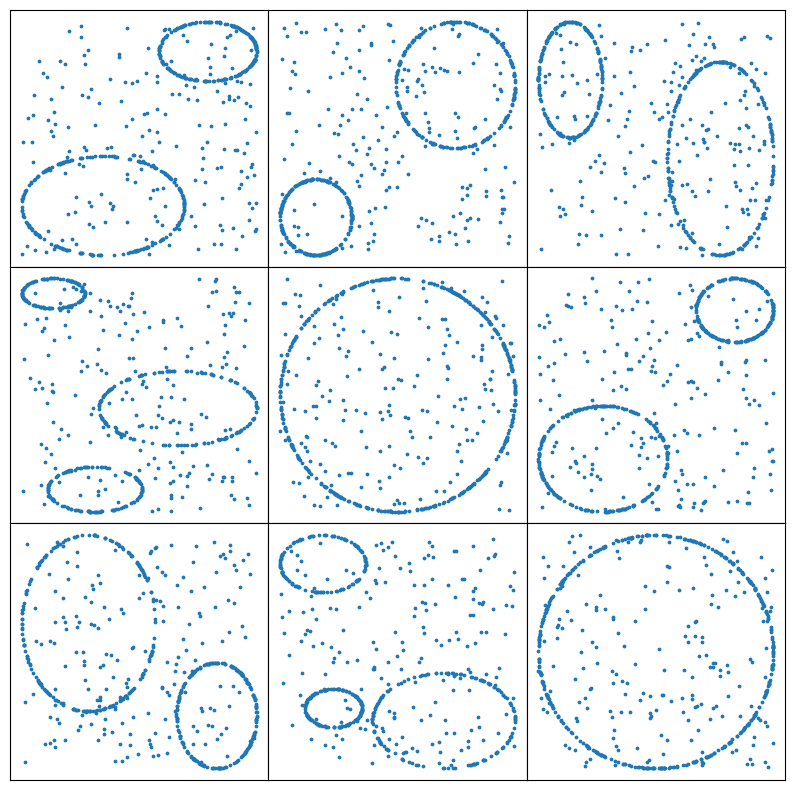

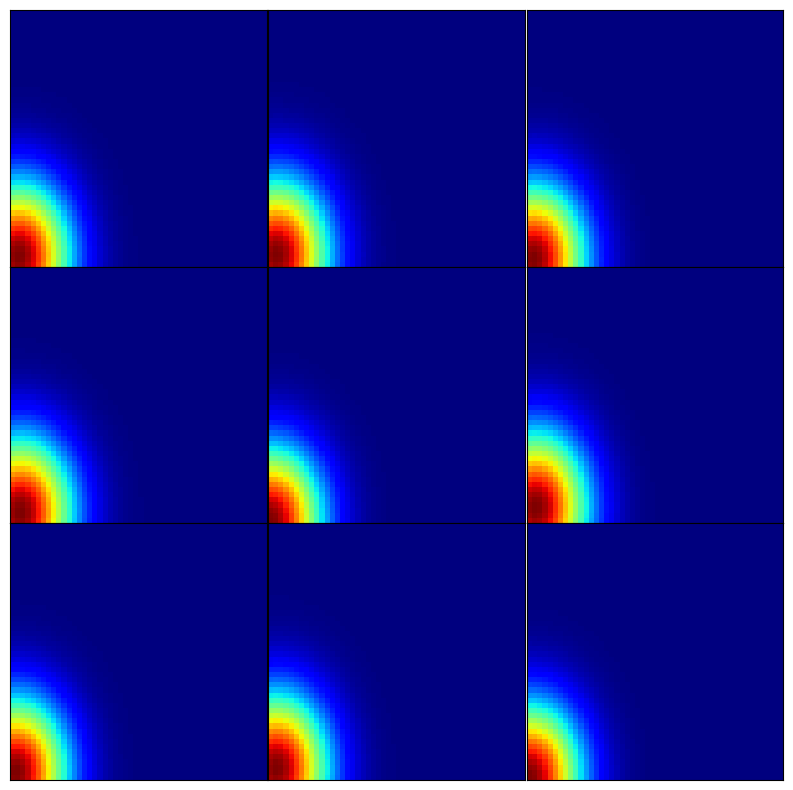

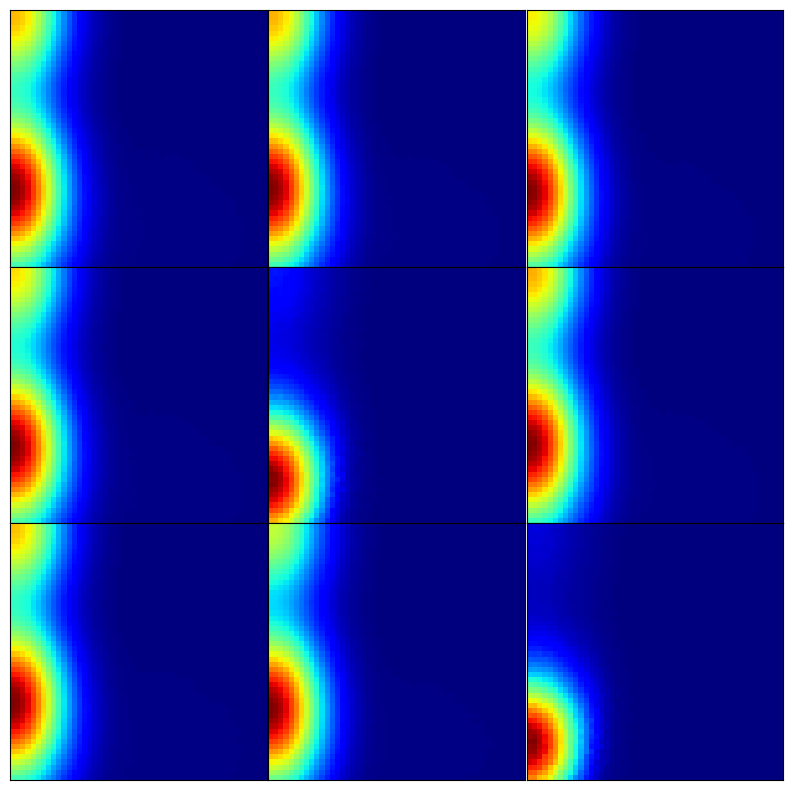

In [59]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        try:
            data = to_numpy(tf_noisy_data_test[idx])
            if data.shape[1] != 2:
                print(f"Skipping idx={idx}, unexpected shape: {data.shape}")
                continue
            ax.scatter(data[:, 0], data[:, 1], s=3)
        except Exception as e:
            print(f"Error at idx={idx} in noisy point cloud: {e}")
            continue

        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_gudhi_pc.png", bbox_inches="tight")
print("Saved noisy_gudhi_pc.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        arr = np.array(noisy_PI_test[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue

        im = np.flip(arr.reshape(50, 50), 0)  # vertical flip
        ax.imshow(im, cmap="jet")
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_gudhi_pi.png", bbox_inches="tight")
print("Saved noisy_gudhi_pi.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        arr = np.array(noisy_PI_prediction[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue

        pred = np.flip(arr.reshape(50, 50), 0)
        ax.imshow(pred, cmap="jet")
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_ripsnet_pi.png", bbox_inches="tight")
print("Saved noisy_ripsnet_pi.png")


In [60]:
label_classif_train_aug = le.transform(label_train)

model_classif_RN = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN.fit(train_PI_prediction, label_classif_train_aug)
clean_test_acc_RN = model_classif_RN.score(clean_PI_prediction, clean_label_classif_test)
noisy_test_acc_RN = model_classif_RN.score(noisy_PI_prediction, noisy_label_classif_test)
print("Accuracy on clean test set = " + str(clean_test_acc_RN))
print("Accuracy on noisy test set = " + str(noisy_test_acc_RN))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:23:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy on clean test set = 0.67
Accuracy on noisy test set = 0.68


Saved clean_gudhi_pc.png
Skipping idx=0, unexpected size: 1500
Skipping idx=1, unexpected size: 1500
Skipping idx=2, unexpected size: 1500
Skipping idx=3, unexpected size: 1500
Skipping idx=4, unexpected size: 1500
Skipping idx=5, unexpected size: 1500
Skipping idx=6, unexpected size: 1500
Skipping idx=7, unexpected size: 1500
Skipping idx=8, unexpected size: 1500
Saved clean_gudhi_pl.png
Skipping idx=0, unexpected size: 1500
Skipping idx=1, unexpected size: 1500
Skipping idx=2, unexpected size: 1500
Skipping idx=3, unexpected size: 1500
Skipping idx=4, unexpected size: 1500
Skipping idx=5, unexpected size: 1500
Skipping idx=6, unexpected size: 1500
Skipping idx=7, unexpected size: 1500
Skipping idx=8, unexpected size: 1500
Saved clean_ripsnet_pl.png


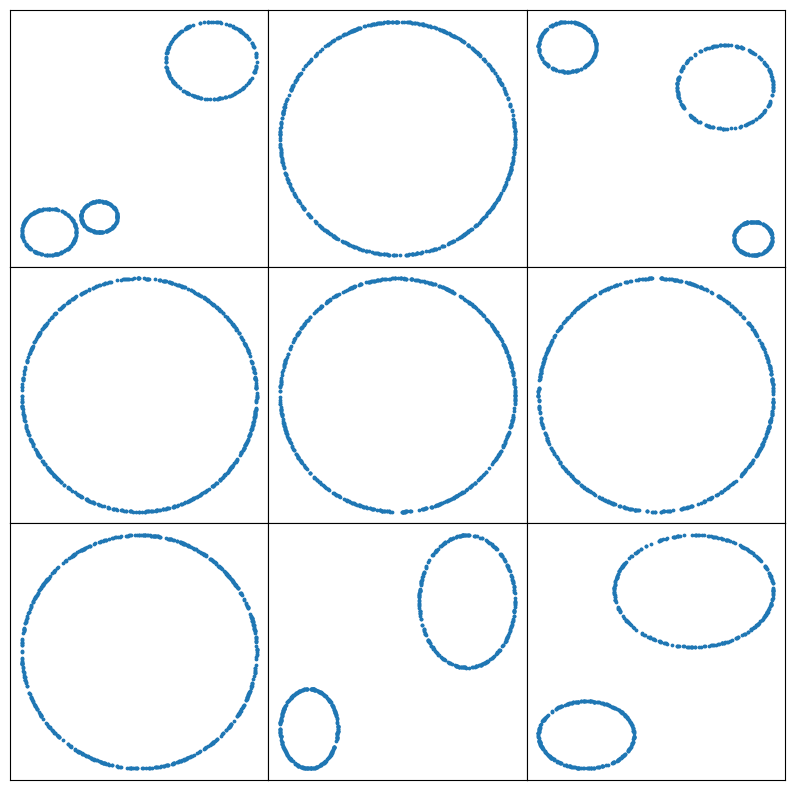

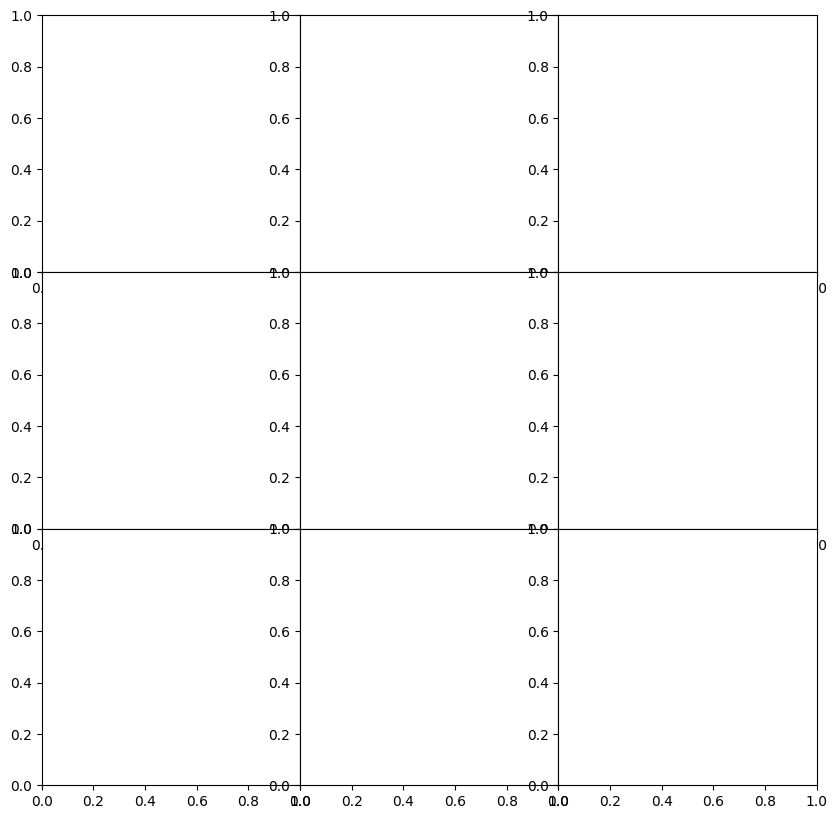

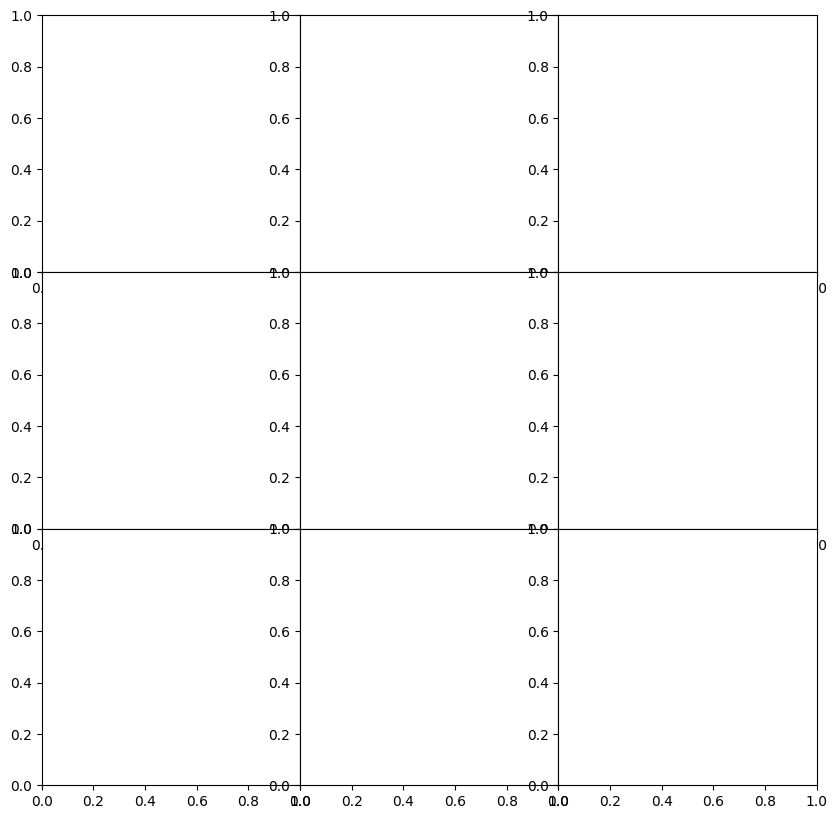

In [61]:


fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        try:
            data = to_numpy(tf_clean_data_test[idx])
            if data.shape[1] != 2:
                print(f"Skipping idx={idx}, unexpected shape: {data.shape}")
                continue
            ax.scatter(data[:, 0], data[:, 1], s=3)
        except Exception as e:
            print(f"Error at idx={idx} in point cloud: {e}")
            continue

        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')
print("Saved clean_gudhi_pc.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        arr = np.array(clean_PL_test[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue

        im = np.flip(arr.reshape(50, 50), 0)  # vertical flip
        ax.imshow(im, cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig('clean_gudhi_pl.png', bbox_inches='tight')
print("Saved clean_gudhi_pl.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])

        arr = np.array(clean_PL_prediction[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue

        pred = np.flip(arr.reshape(50, 50), 0)
        ax.imshow(pred, cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig('clean_ripsnet_pl.png', bbox_inches='tight')
print("Saved clean_ripsnet_pl.png")


In [62]:
model_classif_RN = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN.fit(train_PL_prediction, label_classif_train)
clean_test_acc_RN = model_classif_RN.score(clean_PL_prediction, clean_label_classif_test)
noisy_test_acc_RN = model_classif_RN.score(noisy_PL_prediction, noisy_label_classif_test)
print("Accuracy on clean test set = " + str(clean_test_acc_RN))
print("Accuracy on noisy test set = " + str(noisy_test_acc_RN))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:24:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy on clean test set = 0.7
Accuracy on noisy test set = 0.6733333333333333


In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate Isometry Robustness for RipsNet PI Predictions
clean_ripsnet_pi_isometry_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing RipsNet PI isometry robustness for clean data'):
    score = compute_isometry_robustness_score(pc, model_PI, n_augment_per_score=5, device=device, seed=42)
    clean_ripsnet_pi_isometry_robustness_scores.append(score)

noisy_ripsnet_pi_isometry_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing RipsNet PI isometry robustness for noisy data'):
    score = compute_isometry_robustness_score(pc, model_PI, n_augment_per_score=5, device=device, seed=42)
    noisy_ripsnet_pi_isometry_robustness_scores.append(score)

print(f"Average RipsNet PI isometry robustness score for clean data: {np.mean(clean_ripsnet_pi_isometry_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PI isometry robustness score for clean data: {np.std(clean_ripsnet_pi_isometry_robustness_scores):.6f}")
print(f"Average RipsNet PI isometry robustness score for noisy data: {np.mean(noisy_ripsnet_pi_isometry_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PI isometry robustness score for noisy data: {np.std(noisy_ripsnet_pi_isometry_robustness_scores):.6f}")

# Calculate Isometry Robustness for RipsNet PL Predictions
clean_ripsnet_pl_isometry_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing RipsNet PL isometry robustness for clean data'):
    score = compute_isometry_robustness_score(pc, model_PL, n_augment_per_score=5, device=device, seed=42)
    clean_ripsnet_pl_isometry_robustness_scores.append(score)

noisy_ripsnet_pl_isometry_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing RipsNet PL isometry robustness for noisy data'):
    score = compute_isometry_robustness_score(pc, model_PL, n_augment_per_score=5, device=device, seed=42)
    noisy_ripsnet_pl_isometry_robustness_scores.append(score)

print(f"Average RipsNet PL isometry robustness score for clean data: {np.mean(clean_ripsnet_pl_isometry_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PL isometry robustness score for clean data: {np.std(clean_ripsnet_pl_isometry_robustness_scores):.6f}")
print(f"Average RipsNet PL isometry robustness score for noisy data: {np.mean(noisy_ripsnet_pl_isometry_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PL isometry robustness score for noisy data: {np.std(noisy_ripsnet_pl_isometry_robustness_scores):.6f}")

Computing RipsNet PI isometry robustness for clean data: 100%|██████████| 300/300 [00:01<00:00, 168.67it/s]
Computing RipsNet PI isometry robustness for noisy data: 100%|██████████| 300/300 [00:01<00:00, 237.86it/s]


Average RipsNet PI isometry robustness score for clean data: 0.359474
Standard deviation RipsNet PI isometry robustness score for clean data: 0.325188
Average RipsNet PI isometry robustness score for noisy data: 0.330744
Standard deviation RipsNet PI isometry robustness score for noisy data: 0.302182


Computing RipsNet PL isometry robustness for clean data: 100%|██████████| 300/300 [00:01<00:00, 233.94it/s]
Computing RipsNet PL isometry robustness for noisy data: 100%|██████████| 300/300 [00:01<00:00, 225.62it/s]

Average RipsNet PL isometry robustness score for clean data: 0.643512
Standard deviation RipsNet PL isometry robustness score for clean data: 0.788939
Average RipsNet PL isometry robustness score for noisy data: 0.593332
Standard deviation RipsNet PL isometry robustness score for noisy data: 0.778017


In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate Permutation Robustness for RipsNet PI Predictions
clean_ripsnet_pi_permutation_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing RipsNet PI permutation robustness for clean data'):
    score = compute_permutation_robustness_score(pc, model_PI, n_augment_per_score=5, device=device, seed=42)
    clean_ripsnet_pi_permutation_robustness_scores.append(score)

noisy_ripsnet_pi_permutation_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing RipsNet PI permutation robustness for noisy data'):
    score = compute_permutation_robustness_score(pc, model_PI, n_augment_per_score=5, device=device, seed=42)
    noisy_ripsnet_pi_permutation_robustness_scores.append(score)

print(f"Average RipsNet PI permutation robustness score for clean data: {np.mean(clean_ripsnet_pi_permutation_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PI permutation robustness score for clean data: {np.std(clean_ripsnet_pi_permutation_robustness_scores):.6f}")
print(f"Average RipsNet PI permutation robustness score for noisy data: {np.mean(noisy_ripsnet_pi_permutation_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PI permutation robustness score for noisy data: {np.std(noisy_ripsnet_pi_permutation_robustness_scores):.6f}")

# Calculate Permutation Robustness for RipsNet PL Predictions
clean_ripsnet_pl_permutation_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing RipsNet PL permutation robustness for clean data'):
    score = compute_permutation_robustness_score(pc, model_PL, n_augment_per_score=5, device=device, seed=42)
    clean_ripsnet_pl_permutation_robustness_scores.append(score)

noisy_ripsnet_pl_permutation_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing RipsNet PL permutation robustness for noisy data'):
    score = compute_permutation_robustness_score(pc, model_PL, n_augment_per_score=5, device=device, seed=42)
    noisy_ripsnet_pl_permutation_robustness_scores.append(score)

print(f"Average RipsNet PL permutation robustness score for clean data: {np.mean(clean_ripsnet_pl_permutation_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PL permutation robustness score for clean data: {np.std(clean_ripsnet_pl_permutation_robustness_scores):.6f}")
print(f"Average RipsNet PL permutation robustness score for noisy data: {np.mean(noisy_ripsnet_pl_permutation_robustness_scores):.6f}")
print(f"Standard deviation RipsNet PL permutation robustness score for noisy data: {np.std(noisy_ripsnet_pl_permutation_robustness_scores):.6f}")

Computing RipsNet PI permutation robustness for clean data: 100%|██████████| 300/300 [00:01<00:00, 229.34it/s]
Computing RipsNet PI permutation robustness for noisy data: 100%|██████████| 300/300 [00:01<00:00, 231.62it/s]


Average RipsNet PI permutation robustness score for clean data: 0.000000
Standard deviation RipsNet PI permutation robustness score for clean data: 0.000000
Average RipsNet PI permutation robustness score for noisy data: 0.000000
Standard deviation RipsNet PI permutation robustness score for noisy data: 0.000000


Computing RipsNet PL permutation robustness for clean data: 100%|██████████| 300/300 [00:01<00:00, 226.08it/s]
Computing RipsNet PL permutation robustness for noisy data: 100%|██████████| 300/300 [00:01<00:00, 227.03it/s]

Average RipsNet PL permutation robustness score for clean data: 0.000000
Standard deviation RipsNet PL permutation robustness score for clean data: 0.000000
Average RipsNet PL permutation robustness score for noisy data: 0.000000
Standard deviation RipsNet PL permutation robustness score for noisy data: 0.000000


### DistanceMatrixRagged

In [65]:
# Train an XGBoost classifier on the predictions
model_classif_dm_pi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_dm_pi.fit(dm_train_PI_prediction, label_classif_train)

# Evaluate accuracy on clean test set
clean_test_acc_dm_pi = model_classif_dm_pi.score(dm_clean_PI_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set : {clean_test_acc_dm_pi}")

# Evaluate accuracy on noisy test set
noisy_test_acc_dm_pi = model_classif_dm_pi.score(dm_noisy_PI_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set : {noisy_test_acc_dm_pi}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:24:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy on clean test set : 0.78
Accuracy on noisy test set : 0.8133333333333334


In [66]:
# Train an XGBoost classifier on the predictions
model_classif_dm_pl = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_dm_pl.fit(dm_train_PL_prediction, label_classif_train)

# Evaluate accuracy on clean test set
clean_test_acc_dm_pl = model_classif_dm_pl.score(dm_clean_PL_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set (DistanceMatrixRaggedModel for PI): {clean_test_acc_dm_pi}")

# Evaluate accuracy on noisy test set
noisy_test_acc_dm_pl = model_classif_dm_pl.score(dm_noisy_PL_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set (DistanceMatrixRaggedModel for PI): {noisy_test_acc_dm_pi}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:25:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy on clean test set (DistanceMatrixRaggedModel for PI): 0.78
Accuracy on noisy test set (DistanceMatrixRaggedModel for PI): 0.8133333333333334


In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate Isometry Robustness for DistanceMatrixRaggedModel PI Predictions
clean_dm_pi_isometry_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing DM PI isometry robustness for clean data'):
    score = compute_isometry_robustness_score(pc, model_dm_pi, n_augment_per_score=5, device=device, seed=42)
    clean_dm_pi_isometry_robustness_scores.append(score)

noisy_dm_pi_isometry_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing DM PI isometry robustness for noisy data'):
    score = compute_isometry_robustness_score(pc, model_dm_pi, n_augment_per_score=5, device=device, seed=42)
    noisy_dm_pi_isometry_robustness_scores.append(score)

print(f"Average DM PI isometry robustness score for clean data: {np.mean(clean_dm_pi_isometry_robustness_scores):.6f}")
print(f"Standard deviation DM PI isometry robustness score for clean data: {np.std(clean_dm_pi_isometry_robustness_scores):.6f}")
print(f"Average DM PI isometry robustness score for noisy data: {np.mean(noisy_dm_pi_isometry_robustness_scores):.6f}")
print(f"Standard deviation DM PI isometry robustness score for noisy data: {np.std(noisy_dm_pi_isometry_robustness_scores):.6f}")

# Calculate Isometry Robustness for DistanceMatrixRaggedModel PL Predictions
clean_dm_pl_isometry_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing DM PL isometry robustness for clean data'):
    score = compute_isometry_robustness_score(pc, model_dm_pl, n_augment_per_score=5, device=device, seed=42)
    clean_dm_pl_isometry_robustness_scores.append(score)

noisy_dm_pl_isometry_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing DM PL isometry robustness for noisy data'):
    score = compute_isometry_robustness_score(pc, model_dm_pl, n_augment_per_score=5, device=device, seed=42)
    noisy_dm_pl_isometry_robustness_scores.append(score)

print(f"Average DM PL isometry robustness score for clean data: {np.mean(clean_dm_pl_isometry_robustness_scores):.6f}")
print(f"Standard deviation DM PL isometry robustness score for clean data: {np.std(clean_dm_pl_isometry_robustness_scores):.6f}")
print(f"Average DM PL isometry robustness score for noisy data: {np.mean(noisy_dm_pl_isometry_robustness_scores):.6f}")
print(f"Standard deviation DM PL isometry robustness score for noisy data: {np.std(noisy_dm_pl_isometry_robustness_scores):.6f}")


Computing DM PI isometry robustness for clean data: 100%|██████████| 300/300 [00:26<00:00, 11.41it/s]
Computing DM PI isometry robustness for noisy data: 100%|██████████| 300/300 [00:26<00:00, 11.29it/s]


Average DM PI isometry robustness score for clean data: 0.000000
Standard deviation DM PI isometry robustness score for clean data: 0.000000
Average DM PI isometry robustness score for noisy data: 0.000000
Standard deviation DM PI isometry robustness score for noisy data: 0.000000


Computing DM PL isometry robustness for clean data: 100%|██████████| 300/300 [00:26<00:00, 11.16it/s]
Computing DM PL isometry robustness for noisy data: 100%|██████████| 300/300 [00:26<00:00, 11.23it/s]

Average DM PL isometry robustness score for clean data: 0.000000
Standard deviation DM PL isometry robustness score for clean data: 0.000000
Average DM PL isometry robustness score for noisy data: 0.000000
Standard deviation DM PL isometry robustness score for noisy data: 0.000000


In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate Permutation Robustness for DistanceMatrixRaggedModel PI Predictions
clean_dm_pi_permutation_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing DM PI permutation robustness for clean data'):
    score = compute_permutation_robustness_score(pc, model_dm_pi, n_augment_per_score=5, device=device, seed=42)
    clean_dm_pi_permutation_robustness_scores.append(score)

noisy_dm_pi_permutation_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing DM PI permutation robustness for noisy data'):
    score = compute_permutation_robustness_score(pc, model_dm_pi, n_augment_per_score=5, device=device, seed=42)
    noisy_dm_pi_permutation_robustness_scores.append(score)

print(f"Average DM PI permutation robustness score for clean data: {np.mean(clean_dm_pi_permutation_robustness_scores):.6f}")
print(f"Standard deviation DM PI permutation robustness score for clean data: {np.std(clean_dm_pi_permutation_robustness_scores):.6f}")
print(f"Average DM PI permutation robustness score for noisy data: {np.mean(noisy_dm_pi_permutation_robustness_scores):.6f}")
print(f"Standard deviation DM PI permutation robustness score for noisy data: {np.std(noisy_dm_pi_permutation_robustness_scores):.6f}")

# Calculate Permutation Robustness for DistanceMatrixRaggedModel PL Predictions
clean_dm_pl_permutation_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing DM PL permutation robustness for clean data'):
    score = compute_permutation_robustness_score(pc, model_dm_pl, n_augment_per_score=5, device=device, seed=42)
    clean_dm_pl_permutation_robustness_scores.append(score)

noisy_dm_pl_permutation_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing DM PL permutation robustness for noisy data'):
    score = compute_permutation_robustness_score(pc, model_dm_pl, n_augment_per_score=5, device=device, seed=42)
    noisy_dm_pl_permutation_robustness_scores.append(score)

print(f"Average DM PL permutation robustness score for clean data: {np.mean(clean_dm_pl_permutation_robustness_scores):.6f}")
print(f"Standard deviation DM PL permutation robustness score for clean data: {np.std(clean_dm_pl_permutation_robustness_scores):.6f}")
print(f"Average DM PL permutation robustness score for noisy data: {np.mean(noisy_dm_pl_permutation_robustness_scores):.6f}")
print(f"Standard deviation DM PL permutation robustness score for noisy data: {np.std(noisy_dm_pl_permutation_robustness_scores):.6f}")

Computing DM PI permutation robustness for clean data: 100%|██████████| 300/300 [00:26<00:00, 11.23it/s]
Computing DM PI permutation robustness for noisy data: 100%|██████████| 300/300 [00:27<00:00, 10.89it/s]


Average DM PI permutation robustness score for clean data: 0.886734
Standard deviation DM PI permutation robustness score for clean data: 0.642616
Average DM PI permutation robustness score for noisy data: 0.753816
Standard deviation DM PI permutation robustness score for noisy data: 0.515451


Computing DM PL permutation robustness for clean data: 100%|██████████| 300/300 [00:26<00:00, 11.20it/s]
Computing DM PL permutation robustness for noisy data: 100%|██████████| 300/300 [00:26<00:00, 11.25it/s]

Average DM PL permutation robustness score for clean data: 0.508833
Standard deviation DM PL permutation robustness score for clean data: 0.318749
Average DM PL permutation robustness score for noisy data: 0.437150
Standard deviation DM PL permutation robustness score for noisy data: 0.252243


### PointNet

In [69]:

# Train an XGBoost classifier on the predictions from PointNet (PI)
model_classif_PN_PI = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_PN_PI.fit(pn_train_PI_prediction, label_classif_train)

# Evaluate accuracy on clean test set
clean_test_acc_PN_PI = model_classif_PN_PI.score(pn_clean_PI_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set (PointNet for PI): {clean_test_acc_PN_PI}")

# Evaluate accuracy on noisy test set
noisy_test_acc_PN_PI = model_classif_PN_PI.score(pn_noisy_PI_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set (PointNet for PI): {noisy_test_acc_PN_PI}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:29:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy on clean test set (PointNet for PI): 0.8833333333333333
Accuracy on noisy test set (PointNet for PI): 0.6966666666666667


In [70]:
model_classif_PN_PL = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_PN_PL.fit(pn_train_PL_prediction, label_classif_train)

# Evaluate accuracy on clean test set
clean_test_acc_PN_PL = model_classif_PN_PL.score(pn_clean_PL_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set (PointNet for PL): {clean_test_acc_PN_PL}")

# Evaluate accuracy on noisy test set
noisy_test_acc_PN_PL = model_classif_PN_PL.score(pn_noisy_PL_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set (PointNet for PL): {noisy_test_acc_PN_PL}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:29:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy on clean test set (PointNet for PL): 0.9066666666666666
Accuracy on noisy test set (PointNet for PL): 0.6866666666666666


In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate Isometry Robustness for PointNet PI Predictions
clean_pn_pi_isometry_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing PointNet PI isometry robustness for clean data'):
    score = compute_isometry_robustness_score(pc, model_PN_PI, n_augment_per_score=5, device=device, seed=42)
    clean_pn_pi_isometry_robustness_scores.append(score)

noisy_pn_pi_isometry_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing PointNet PI isometry robustness for noisy data'):
    score = compute_isometry_robustness_score(pc, model_PN_PI, n_augment_per_score=5, device=device, seed=42)
    noisy_pn_pi_isometry_robustness_scores.append(score)

print(f"Average PointNet PI isometry robustness score for clean data: {np.mean(clean_pn_pi_isometry_robustness_scores):.6f}")
print(f"Standard deviation PointNet PI isometry robustness score for clean data: {np.std(clean_pn_pi_isometry_robustness_scores):.6f}")
print(f"Average PointNet PI isometry robustness score for noisy data: {np.mean(noisy_pn_pi_isometry_robustness_scores):.6f}")
print(f"Standard deviation PointNet PI isometry robustness score for noisy data: {np.std(noisy_pn_pi_isometry_robustness_scores):.6f}")

# Calculate Isometry Robustness for PointNet PL Predictions
clean_pn_pl_isometry_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing PointNet PL isometry robustness for clean data'):
    score = compute_isometry_robustness_score(pc, model_PN_PL, n_augment_per_score=5, device=device, seed=42)
    clean_pn_pl_isometry_robustness_scores.append(score)

noisy_pn_pl_isometry_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing PointNet PL isometry robustness for noisy data'):
    score = compute_isometry_robustness_score(pc, model_PN_PL, n_augment_per_score=5, device=device, seed=42)
    noisy_pn_pl_isometry_robustness_scores.append(score)

print(f"Average PointNet PL isometry robustness score for clean data: {np.mean(clean_pn_pl_isometry_robustness_scores):.6f}")
print(f"Standard deviation PointNet PL isometry robustness score for clean data: {np.std(clean_pn_pl_isometry_robustness_scores):.6f}")
print(f"Average PointNet PL isometry robustness score for noisy data: {np.mean(noisy_pn_pl_isometry_robustness_scores):.6f}")
print(f"Standard deviation PointNet PL isometry robustness score for noisy data: {np.std(noisy_pn_pl_isometry_robustness_scores):.6f}")

Computing PointNet PI isometry robustness for clean data: 100%|██████████| 300/300 [00:01<00:00, 207.21it/s]
Computing PointNet PI isometry robustness for noisy data: 100%|██████████| 300/300 [00:01<00:00, 165.16it/s]


Average PointNet PI isometry robustness score for clean data: 0.657250
Standard deviation PointNet PI isometry robustness score for clean data: 0.320870
Average PointNet PI isometry robustness score for noisy data: 0.693894
Standard deviation PointNet PI isometry robustness score for noisy data: 0.312124


Computing PointNet PL isometry robustness for clean data: 100%|██████████| 300/300 [00:01<00:00, 172.66it/s]
Computing PointNet PL isometry robustness for noisy data: 100%|██████████| 300/300 [00:01<00:00, 196.97it/s]

Average PointNet PL isometry robustness score for clean data: 0.394176
Standard deviation PointNet PL isometry robustness score for clean data: 0.211278
Average PointNet PL isometry robustness score for noisy data: 0.416406
Standard deviation PointNet PL isometry robustness score for noisy data: 0.182998


In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate Permutation Robustness for PointNet PI Predictions
clean_pn_pi_permutation_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing PointNet PI permutation robustness for clean data'):
    score = compute_permutation_robustness_score(pc, model_PN_PI, n_augment_per_score=5, device=device, seed=42)
    clean_pn_pi_permutation_robustness_scores.append(score)

noisy_pn_pi_permutation_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing PointNet PI permutation robustness for noisy data'):
    score = compute_permutation_robustness_score(pc, model_PN_PI, n_augment_per_score=5, device=device, seed=42)
    noisy_pn_pi_permutation_robustness_scores.append(score)

print(f"Average PointNet PI permutation robustness score for clean data: {np.mean(clean_pn_pi_permutation_robustness_scores):.6f}")
print(f"Standard deviation PointNet PI permutation robustness score for clean data: {np.std(clean_pn_pi_permutation_robustness_scores):.6f}")
print(f"Average PointNet PI permutation robustness score for noisy data: {np.mean(noisy_pn_pi_permutation_robustness_scores):.6f}")
print(f"Standard deviation PointNet PI permutation robustness score for noisy data: {np.std(noisy_pn_pi_permutation_robustness_scores):.6f}")

# Calculate Permutation Robustness for PointNet PL Predictions
clean_pn_pl_permutation_robustness_scores = []
for pc in tqdm(clean_data_test, desc='Computing PointNet PL permutation robustness for clean data'):
    score = compute_permutation_robustness_score(pc, model_PN_PL, n_augment_per_score=5, device=device, seed=42)
    clean_pn_pl_permutation_robustness_scores.append(score)

noisy_pn_pl_permutation_robustness_scores = []
for pc in tqdm(noisy_data_test, desc='Computing PointNet PL permutation robustness for noisy data'):
    score = compute_permutation_robustness_score(pc, model_PN_PL, n_augment_per_score=5, device=device, seed=42)
    noisy_pn_pl_permutation_robustness_scores.append(score)

print(f"Average PointNet PL permutation robustness score for clean data: {np.mean(clean_pn_pl_permutation_robustness_scores):.6f}")
print(f"Standard deviation PointNet PL permutation robustness score for clean data: {np.std(clean_pn_pl_permutation_robustness_scores):.6f}")
print(f"Average PointNet PL permutation robustness score for noisy data: {np.mean(noisy_pn_pl_permutation_robustness_scores):.6f}")
print(f"Standard deviation PointNet PL permutation robustness score for noisy data: {np.std(noisy_pn_pl_permutation_robustness_scores):.6f}")

Computing PointNet PI permutation robustness for clean data: 100%|██████████| 300/300 [00:01<00:00, 205.28it/s]
Computing PointNet PI permutation robustness for noisy data: 100%|██████████| 300/300 [00:01<00:00, 212.65it/s]


Average PointNet PI permutation robustness score for clean data: 0.000000
Standard deviation PointNet PI permutation robustness score for clean data: 0.000000
Average PointNet PI permutation robustness score for noisy data: 0.000000
Standard deviation PointNet PI permutation robustness score for noisy data: 0.000000


Computing PointNet PL permutation robustness for clean data: 100%|██████████| 300/300 [00:01<00:00, 213.25it/s]
Computing PointNet PL permutation robustness for noisy data: 100%|██████████| 300/300 [00:01<00:00, 207.38it/s]

Average PointNet PL permutation robustness score for clean data: 0.000000
Standard deviation PointNet PL permutation robustness score for clean data: 0.000000
Average PointNet PL permutation robustness score for noisy data: 0.000000
Standard deviation PointNet PL permutation robustness score for noisy data: 0.000000


### Linear Ensemble

In [73]:
clean_ensemble_acc_pi = ensemble_model_pi.score(ensemble_clean_test_proba_pi, clean_label_classif_test)
print(f"Ensemble Accuracy on clean test set (PI): {clean_ensemble_acc_pi:.4f}")

noisy_ensemble_acc_pi = ensemble_model_pi.score(ensemble_noisy_test_proba_pi, noisy_label_classif_test)
print(f"Ensemble Accuracy on noisy test set (PI): {noisy_ensemble_acc_pi:.4f}")


Ensemble Accuracy on clean test set (PI): 0.8300
Ensemble Accuracy on noisy test set (PI): 0.7500


In [74]:
# 5. Evaluate accuracy on clean test set for PL
clean_ensemble_acc_pl = ensemble_model_pl.score(ensemble_clean_test_proba_pl, clean_label_classif_test)
print(f"Ensemble Accuracy on clean test set (PL): {clean_ensemble_acc_pl:.4f}")


# 7. Evaluate accuracy on noisy test set for PL
noisy_ensemble_acc_pl = ensemble_model_pl.score(ensemble_noisy_test_proba_pl, noisy_label_classif_test)
print(f"Ensemble Accuracy on noisy test set (PL): {noisy_ensemble_acc_pl:.4f}")


Ensemble Accuracy on clean test set (PL): 0.8633
Ensemble Accuracy on noisy test set (PL): 0.7100


In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_augment = 5

print("\n--- Ensemble PI Isometry Robustness ---")
clean_ensemble_pi_isometry_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PI Isometry (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_isometries, n_augment, device, 'pi')
    clean_ensemble_pi_isometry_scores.append(mean_dist)

noisy_ensemble_pi_isometry_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PI Isometry (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_isometries, n_augment, device, 'pi')
    noisy_ensemble_pi_isometry_scores.append(mean_dist)

print(f"Avg Ensemble PI Isometry (Clean): {np.mean(clean_ensemble_pi_isometry_scores):.6f} ± {np.std(clean_ensemble_pi_isometry_scores):.6f}")
print(f"Avg Ensemble PI Isometry (Noisy): {np.mean(noisy_ensemble_pi_isometry_scores):.6f} ± {np.std(noisy_ensemble_pi_isometry_scores):.6f}")


print("\n--- Ensemble PI Permutation Robustness ---")
clean_ensemble_pi_permutation_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PI Permutation (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_permutations, n_augment, device, 'pi')
    clean_ensemble_pi_permutation_scores.append(mean_dist)

noisy_ensemble_pi_permutation_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PI Permutation (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pi, augment_permutations, n_augment, device, 'pi')
    noisy_ensemble_pi_permutation_scores.append(mean_dist)

print(f"Avg Ensemble PI Permutation (Clean): {np.mean(clean_ensemble_pi_permutation_scores):.6f} ± {np.std(clean_ensemble_pi_permutation_scores):.6f}")
print(f"Avg Ensemble PI Permutation (Noisy): {np.mean(noisy_ensemble_pi_permutation_scores):.6f} ± {np.std(noisy_ensemble_pi_permutation_scores):.6f}")


print("\n--- Ensemble PL Isometry Robustness ---")
clean_ensemble_pl_isometry_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PL Isometry (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_isometries, n_augment, device, 'pl')
    clean_ensemble_pl_isometry_scores.append(mean_dist)

noisy_ensemble_pl_isometry_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PL Isometry (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_isometries, n_augment, device, 'pl')
    noisy_ensemble_pl_isometry_scores.append(mean_dist)

print(f"Avg Ensemble PL Isometry (Clean): {np.mean(clean_ensemble_pl_isometry_scores):.6f} ± {np.std(clean_ensemble_pl_isometry_scores):.6f}")
print(f"Avg Ensemble PL Isometry (Noisy): {np.mean(noisy_ensemble_pl_isometry_scores):.6f} ± {np.std(noisy_ensemble_pl_isometry_scores):.6f}")


print("\n--- Ensemble PL Permutation Robustness ---")
clean_ensemble_pl_permutation_scores = []
for pc in tqdm(clean_data_test, desc='Ensemble PL Permutation (Clean)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_permutations, n_augment, device, 'pl')
    clean_ensemble_pl_permutation_scores.append(mean_dist)

noisy_ensemble_pl_permutation_scores = []
for pc in tqdm(noisy_data_test, desc='Ensemble PL Permutation (Noisy)'):
    mean_dist, _ = compute_ensemble_robustness(pc, ensemble_model_pl, augment_permutations, n_augment, device, 'pl')
    noisy_ensemble_pl_permutation_scores.append(mean_dist)

print(f"Avg Ensemble PL Permutation (Clean): {np.mean(clean_ensemble_pl_permutation_scores):.6f} ± {np.std(clean_ensemble_pl_permutation_scores):.6f}")
print(f"Avg Ensemble PL Permutation (Noisy): {np.mean(noisy_ensemble_pl_permutation_scores):.6f} ± {np.std(noisy_ensemble_pl_permutation_scores):.6f}")


--- Ensemble PI Isometry Robustness ---


Ensemble PI Isometry (Noisy): 100%|██████████| 300/300 [01:30<00:00,  3.31it/s]


Avg Ensemble PI Isometry (Clean): 0.185107 ± 0.150679
Avg Ensemble PI Isometry (Noisy): 0.093771 ± 0.131662

--- Ensemble PI Permutation Robustness ---


Ensemble PI Permutation (Noisy): 100%|██████████| 300/300 [01:54<00:00,  2.62it/s]


Avg Ensemble PI Permutation (Clean): 0.158921 ± 0.144701
Avg Ensemble PI Permutation (Noisy): 0.061479 ± 0.082886

--- Ensemble PL Isometry Robustness ---


Ensemble PL Isometry (Noisy): 100%|██████████| 300/300 [01:00<00:00,  4.99it/s]


Avg Ensemble PL Isometry (Clean): 0.000001 ± 0.000001
Avg Ensemble PL Isometry (Noisy): 0.000001 ± 0.000001

--- Ensemble PL Permutation Robustness ---


Ensemble PL Permutation (Noisy): 100%|██████████| 300/300 [00:49<00:00,  6.01it/s]

Avg Ensemble PL Permutation (Clean): 0.000014 ± 0.000014
Avg Ensemble PL Permutation (Noisy): 0.000011 ± 0.000010


In [79]:
print("Coefficients for ensemble_model_pi:\n", ensemble_model_pi.coef_)
print("Intercept for ensemble_model_pi:\n", ensemble_model_pi.intercept_)

Coefficients for ensemble_model_pi:
 [[ 1.98257317 -1.45967067 -1.46102947  1.98707673 -1.46353071 -1.46167303
   1.98630434 -1.46317306 -1.46125827]
 [-1.4597161   1.94618375 -1.42251249 -1.46395251  2.03939065 -1.51148293
  -1.46323918  2.04495839 -1.51776403]
 [-1.46140235 -1.42220278  1.94759991 -1.46209572 -1.51148334  2.03757386
  -1.46172869 -1.5175624   2.04328587]]
Intercept for ensemble_model_pi:
 [-0.938127   -0.93604481 -0.93600521]


In [80]:
print("Coefficients for ensemble_model_pl:\n", ensemble_model_pl.coef_)
print("Intercept for ensemble_model_pl:\n", ensemble_model_pl.intercept_)

Coefficients for ensemble_model_pl:
 [[ 1.98218815 -1.45930688 -1.46121639  1.98663164 -1.46380354 -1.46116325
   1.9863625  -1.46356217 -1.46113545]
 [-1.45941088  1.95830389 -1.43498003 -1.46396696  2.03124445 -1.50336451
  -1.46375346  2.0373397  -1.50967327]
 [-1.46129896 -1.43496619  1.96024426 -1.46152093 -1.50320209  2.02870216
  -1.46135399 -1.50956846  2.03490156]]
Intercept for ensemble_model_pl:
 [-0.93833512 -0.93608702 -0.93602088]


#### NormModel

In [81]:
model_ppT_trace_pi.eval()

with torch.no_grad():
    ppT_trace_train_tensor = torch.tensor(ppT_trace_train, dtype=torch.float32).to(device)
    ppT_trace_clean_test_tensor = torch.tensor(ppT_trace_clean_test, dtype=torch.float32).to(device)
    ppT_trace_noisy_test_tensor = torch.tensor(ppT_trace_noisy_test, dtype=torch.float32).to(device)

    ppT_trace_train_PI_prediction = model_ppT_trace_pi(ppT_trace_train_tensor.unsqueeze(1)).cpu().numpy()
    ppT_trace_clean_PI_prediction = model_ppT_trace_pi(ppT_trace_clean_test_tensor.unsqueeze(1)).cpu().numpy()
    ppT_trace_noisy_PI_prediction = model_ppT_trace_pi(ppT_trace_noisy_test_tensor.unsqueeze(1)).cpu().numpy()

print("Predictions computed for ScalarInputMLP for PI:")
print(f"ppT_trace_train_PI_prediction shape: {ppT_trace_train_PI_prediction.shape}")
print(f"ppT_trace_clean_PI_prediction shape: {ppT_trace_clean_PI_prediction.shape}")
print(f"ppT_trace_noisy_PI_prediction shape: {ppT_trace_noisy_PI_prediction.shape}")

model_classif_ppT_trace_pi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_ppT_trace_pi.fit(ppT_trace_train_PI_prediction, label_classif_train)

clean_test_acc_ppT_trace_pi = model_classif_ppT_trace_pi.score(ppT_trace_clean_PI_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set (ScalarInputMLP for PI): {clean_test_acc_ppT_trace_pi:.4f}")

noisy_test_acc_ppT_trace_pi = model_classif_ppT_trace_pi.score(ppT_trace_noisy_PI_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set (ScalarInputMLP for PI): {noisy_test_acc_ppT_trace_pi:.4f}")

Predictions computed for ScalarInputMLP for PI:
ppT_trace_train_PI_prediction shape: (900, 2500)
ppT_trace_clean_PI_prediction shape: (300, 2500)
ppT_trace_noisy_PI_prediction shape: (300, 2500)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:53:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy on clean test set (ScalarInputMLP for PI): 0.6500
Accuracy on noisy test set (ScalarInputMLP for PI): 0.6800


In [82]:
model_ppT_trace_pl.eval()

with torch.no_grad():
    ppT_trace_train_tensor = torch.tensor(ppT_trace_train, dtype=torch.float32).to(device)
    ppT_trace_clean_test_tensor = torch.tensor(ppT_trace_clean_test, dtype=torch.float32).to(device)
    ppT_trace_noisy_test_tensor = torch.tensor(ppT_trace_noisy_test, dtype=torch.float32).to(device)

    ppT_trace_train_PL_prediction = model_ppT_trace_pl(ppT_trace_train_tensor.unsqueeze(1)).cpu().numpy()
    ppT_trace_clean_PL_prediction = model_ppT_trace_pl(ppT_trace_clean_test_tensor.unsqueeze(1)).cpu().numpy()
    ppT_trace_noisy_PL_prediction = model_ppT_trace_pl(ppT_trace_noisy_test_tensor.unsqueeze(1)).cpu().numpy()

print("Predictions computed for ScalarInputMLP for PL:")
print(f"ppT_trace_train_PL_prediction shape: {ppT_trace_train_PL_prediction.shape}")
print(f"ppT_trace_clean_PL_prediction shape: {ppT_trace_clean_PL_prediction.shape}")
print(f"ppT_trace_noisy_PL_prediction shape: {ppT_trace_noisy_PL_prediction.shape}")

model_classif_ppT_trace_pl = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_ppT_trace_pl.fit(ppT_trace_train_PL_prediction, label_classif_train)

clean_test_acc_ppT_trace_pl = model_classif_ppT_trace_pl.score(ppT_trace_clean_PL_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set (ScalarInputMLP for PL): {clean_test_acc_ppT_trace_pl:.4f}")

noisy_test_acc_ppT_trace_pl = model_classif_ppT_trace_pl.score(ppT_trace_noisy_PL_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set (ScalarInputMLP for PL): {noisy_test_acc_ppT_trace_pl:.4f}")

Predictions computed for ScalarInputMLP for PL:
ppT_trace_train_PL_prediction shape: (900, 1500)
ppT_trace_clean_PL_prediction shape: (300, 1500)
ppT_trace_noisy_PL_prediction shape: (300, 1500)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:53:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy on clean test set (ScalarInputMLP for PL): 0.6367
Accuracy on noisy test set (ScalarInputMLP for PL): 0.6600


### MultiInputModel

In [83]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_multi_pi.eval()

with torch.no_grad():
    multi_train_pc_list = [pc.to(device).float() for pc in tf_data_train]
    multi_clean_test_pc_list = [pc.to(device).float() for pc in tf_clean_data_test]
    multi_noisy_test_pc_list = [pc.to(device).float() for pc in tf_noisy_data_test]

    multi_train_scalar_input = torch.tensor(ppT_trace_train_PI_prediction, dtype=torch.float32).to(device)
    multi_clean_test_scalar_input = torch.tensor(ppT_trace_clean_PI_prediction, dtype=torch.float32).to(device)
    multi_noisy_test_scalar_input = torch.tensor(ppT_trace_noisy_PI_prediction, dtype=torch.float32).to(device)

    multi_train_PI_prediction = model_multi_pi(multi_train_pc_list, multi_train_scalar_input).cpu().numpy()
    multi_clean_PI_prediction = model_multi_pi(multi_clean_test_pc_list, multi_clean_test_scalar_input).cpu().numpy()
    multi_noisy_PI_prediction = model_multi_pi(multi_noisy_test_pc_list, multi_noisy_test_scalar_input).cpu().numpy()

print("Predictions computed for MultiInputModel for PI:")
print(f"multi_train_PI_prediction shape: {multi_train_PI_prediction.shape}")
print(f"multi_clean_PI_prediction shape: {multi_clean_PI_prediction.shape}")
print(f"multi_noisy_PI_prediction shape: {multi_noisy_PI_prediction.shape}")

model_classif_multi_pi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_multi_pi.fit(multi_train_PI_prediction, label_classif_train)

clean_test_acc_multi_pi = model_classif_multi_pi.score(multi_clean_PI_prediction, clean_label_classif_test)
print(f"Accuracy on clean test set (MultiInputModel for PI): {clean_test_acc_multi_pi:.4f}")

noisy_test_acc_multi_pi = model_classif_multi_pi.score(multi_noisy_PI_prediction, noisy_label_classif_test)
print(f"Accuracy on noisy test set (MultiInputModel for PI): {noisy_test_acc_multi_pi:.4f}")


Predictions computed for MultiInputModel for PI:
multi_train_PI_prediction shape: (900, 2500)
multi_clean_PI_prediction shape: (300, 2500)
multi_noisy_PI_prediction shape: (300, 2500)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:53:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy on clean test set (MultiInputModel for PI): 0.8933
Accuracy on noisy test set (MultiInputModel for PI): 0.6167


## Comparisons of the different Models